In [ ]:
!rm -rf sample_data/ #extra space freeing

In [ ]:
!unzip SCUT_FBP5500_downsampled.zip

Streaming output truncated to the last 5000 lines.
  inflating: test/3_AM653.jpg        
  inflating: test/3_AM666.jpg        
  inflating: test/3_AM682.jpg        
  inflating: test/3_AM702.jpg        
  inflating: test/3_AM716.jpg        
  inflating: test/3_AM741.jpg        
  inflating: test/3_AM751.jpg        
  inflating: test/3_AM767.jpg        
  inflating: test/3_AM780.jpg        
  inflating: test/3_AM794.jpg        
  inflating: test/3_AM810.jpg        
  inflating: test/3_AM827.jpg        
  inflating: test/3_AM837.jpg        
  inflating: test/3_AM848.jpg        
  inflating: test/3_AM865.jpg        
  inflating: test/3_AM884.jpg        
  inflating: test/3_AM899.jpg        
  inflating: test/3_AM909.jpg        
  inflating: test/3_AM919.jpg        
  inflating: test/3_AM933.jpg        
  inflating: test/3_AM954.jpg        
  inflating: test/3_AM978.jpg        
  inflating: test/3_AM989.jpg        
  inflating: test/3_AM998.jpg        
  inflating: test/3_CF115.jpg        

# Seeding For reproducability

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf

def set_global_seed(seed=42):
    # 1. Python built-in RNG
    random.seed(seed)

    # 2. NumPy RNG
    np.random.seed(seed)

    # 3. TensorFlow RNG
    tf.random.set_seed(seed)

    # 4. (Optional) CUDA / cuDNN determinism
    os.environ["TF_DETERMINISTIC_OPS"] = "1"   # makes conv/pool deterministic
    os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

    print(f"✅ Global seed set to {seed}")

# Call this once, at the top of your notebook / main.py
set_global_seed(1234)

✅ Global seed set to 1234


# Dataset Loading

In [ ]:
import tensorflow as tf

# Check if tensorflow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
import tensorflow as tf
import os

def parse_label_from_path(path):
    fname = tf.strings.regex_replace(path, r".*[\\/]", "")          # -> b"7_CM668.jpg"
    # 2) grab the leading integer before the underscore
    num   = tf.strings.regex_replace(fname, r"^([0-9]+)_.*$", r"\1")# -> b"7"
    # 3) to float and shape (1,) for regression
    label = tf.strings.to_number(num, out_type=tf.float32)
    return tf.reshape(label, [1])  # regression target shape [1]

def process_img(path):
    img = tf.io.decode_jpeg(tf.io.read_file(path), channels=3)
    img = tf.image.resize(img, (80, 80)) / 255.0
    y = parse_label_from_path(path)
    return img, y  # <-- (features, label)

train_dataset = (tf.data.Dataset.list_files("training/*.jpg")).map(process_img,num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
validation_dataset = (tf.data.Dataset.list_files("validation/*.jpg")).map(process_img,num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

Checking the dataset whether it is correct

In [ ]:
import tensorflow as tf

print("train cardinality:", tf.data.experimental.cardinality(train_dataset))
print("val cardinality  :", tf.data.experimental.cardinality(validation_dataset))

for xb, yb in train_dataset.batch(32).take(1):
    print("first train batch:", xb.shape, yb.shape)
for xb, yb in train_dataset.batch(32).skip(111).take(1):  # last step
    print("last  train batch:", xb.shape, yb.shape)       # expect (3, 80, 80, 3)

train cardinality: tf.Tensor(3555, shape=(), dtype=int64)
val cardinality  : tf.Tensor(893, shape=(), dtype=int64)
first train batch: (32, 80, 80, 3) (32, 1)
last  train batch: (3, 80, 80, 3) (3, 1)


In [ ]:
%ls training | wc -l
%ls validation | wc -l
!nproc

3555
893
12


Sample numbers are correct for training validation
Input image dimensions are correct B,H,W,C and 1 dimension for

In [ ]:
def dataset_stats(ds, batch_size=32):
    """
    Computes min, max, mean, std for images and labels.
    - Assumes each element is (image, label) with image float in [0,1] and label shape (1,) or ().
    - Returns dict with global image stats (over all pixels) and per-channel stats,
      and label stats (over samples).
    """
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # Global image stats (all pixels), and per-channel stats
    img_min = tf.constant(float('inf'), tf.float32)
    img_max = tf.constant(float('-inf'), tf.float32)
    img_sum = tf.constant(0.0, tf.float32)
    img_sumsq = tf.constant(0.0, tf.float32)
    img_count = tf.constant(0.0, tf.float32)

    ch_sum = None
    ch_sumsq = None
    ch_count = None

    # Label stats (per sample)
    y_min = tf.constant(float('inf'), tf.float32)
    y_max = tf.constant(float('-inf'), tf.float32)
    y_sum = tf.constant(0.0, tf.float32)
    y_sumsq = tf.constant(0.0, tf.float32)
    y_count = tf.constant(0.0, tf.float32)

    for xb, yb in ds:
        # Ensure float32
        xb = tf.cast(xb, tf.float32)
        yb = tf.cast(yb, tf.float32)

        # ----- images: global -----
        img_min = tf.minimum(img_min, tf.reduce_min(xb))
        img_max = tf.maximum(img_max, tf.reduce_max(xb))
        img_sum += tf.reduce_sum(xb)
        img_sumsq += tf.reduce_sum(tf.square(xb))
        img_count += tf.cast(tf.size(xb), tf.float32)

        # ----- images: per-channel -----
        # reduce over N, H, W; keep C
        ch_axes = [0, 1, 2]  # assuming NHWC
        cur_ch_sum = tf.reduce_sum(xb, axis=ch_axes)         # shape (C,)
        cur_ch_sumsq = tf.reduce_sum(tf.square(xb), axis=ch_axes)  # (C,)
        cur_ch_count = tf.cast(tf.reduce_prod(tf.shape(xb)[:3]), tf.float32)  # N*H*W
        if ch_sum is None:
            ch_sum = cur_ch_sum
            ch_sumsq = cur_ch_sumsq
            ch_count = cur_ch_count
        else:
            ch_sum += cur_ch_sum
            ch_sumsq += cur_ch_sumsq
            ch_count += cur_ch_count

        # ----- labels -----
        y_min = tf.minimum(y_min, tf.reduce_min(yb))
        y_max = tf.maximum(y_max, tf.reduce_max(yb))
        y_sum += tf.reduce_sum(yb)
        y_sumsq += tf.reduce_sum(tf.square(yb))
        y_count += tf.cast(tf.size(yb), tf.float32)  # count of label scalars

    # finalize
    img_mean = img_sum / tf.maximum(img_count, 1.0)
    img_var = tf.maximum(img_sumsq / tf.maximum(img_count, 1.0) - tf.square(img_mean), 0.0)
    img_std = tf.sqrt(img_var)

    ch_mean = ch_sum / tf.maximum(ch_count, 1.0) if ch_sum is not None else None
    ch_var = tf.maximum(ch_sumsq / tf.maximum(ch_count, 1.0) - tf.square(ch_mean), 0.0) if ch_sum is not None else None
    ch_std = tf.sqrt(ch_var) if ch_var is not None else None

    y_mean = y_sum / tf.maximum(y_count, 1.0)
    y_var = tf.maximum(y_sumsq / tf.maximum(y_count, 1.0) - tf.square(y_mean), 0.0)
    y_std = tf.sqrt(y_var)

    return {
        "image_global": {"min": float(img_min.numpy()),
                         "max": float(img_max.numpy()),
                         "mean": float(img_mean.numpy()),
                         "std":  float(img_std.numpy())},
        "image_per_channel": None if ch_sum is None else {
            "mean": ch_mean.numpy().tolist(),
            "std":  ch_std.numpy().tolist(),
        },
        "labels": {"min": float(y_min.numpy()),
                   "max": float(y_max.numpy()),
                   "mean": float(y_mean.numpy()),
                   "std":  float(y_std.numpy())}
    }

# ---- run on your datasets (unbatched ds expected) ----
train_stats = dataset_stats(train_dataset, batch_size=32)
val_stats   = dataset_stats(validation_dataset, batch_size=32)

print("TRAIN image (global):", train_stats["image_global"])
print("TRAIN image (per-channel RGB):", train_stats["image_per_channel"])
print("TRAIN labels:", train_stats["labels"])

print("VAL image (global):", val_stats["image_global"])
print("VAL image (per-channel RGB):", val_stats["image_per_channel"])
print("VAL labels:", val_stats["labels"])


TRAIN image (global): {'min': 0.0, 'max': 1.0, 'mean': 0.4945290684700012, 'std': 0.29457250237464905}
TRAIN image (per-channel RGB): {'mean': [0.6062124371528625, 0.4732199013233185, 0.4041549861431122], 'std': [0.3239644765853882, 0.2707996964454651, 0.2468571960926056]}
TRAIN labels: {'min': 1.0, 'max': 8.0, 'mean': 4.056540012359619, 'std': 1.9739253520965576}
VAL image (global): {'min': 0.0, 'max': 1.0, 'mean': 0.4917309284210205, 'std': 0.293306440114975}
VAL image (per-channel RGB): {'mean': [0.6028152704238892, 0.4702852964401245, 0.40209218859672546], 'std': [0.321927934885025, 0.2697136104106903, 0.24671496450901031]}
VAL labels: {'min': 1.0, 'max': 8.0, 'mean': 4.053751468658447, 'std': 1.975612759590149}


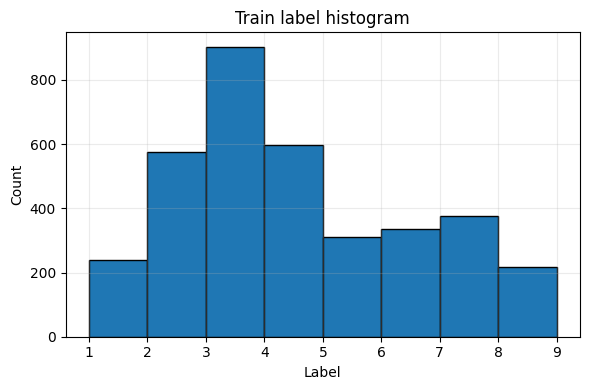

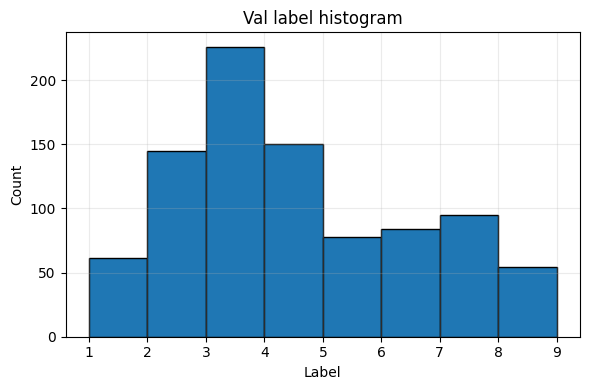

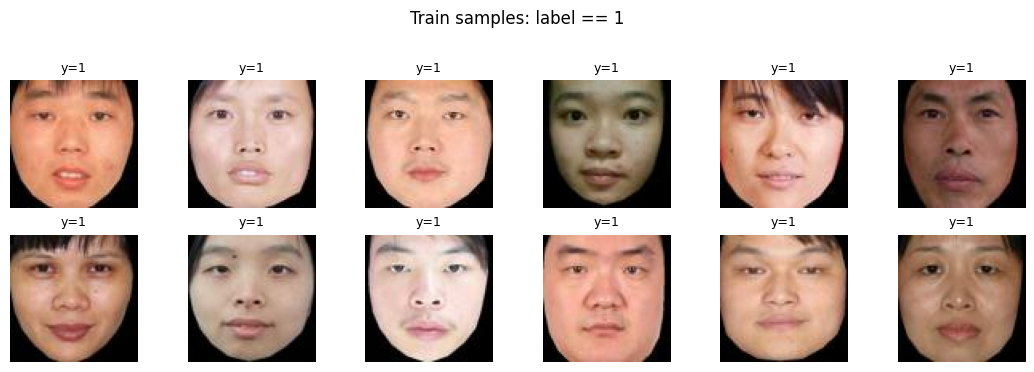

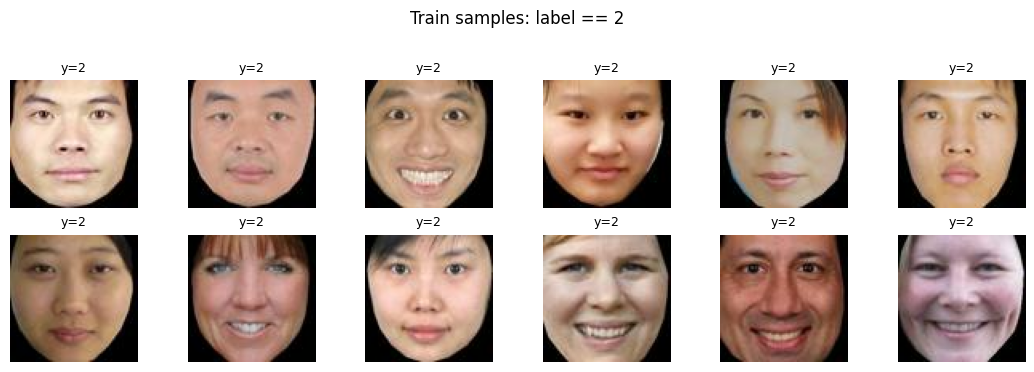

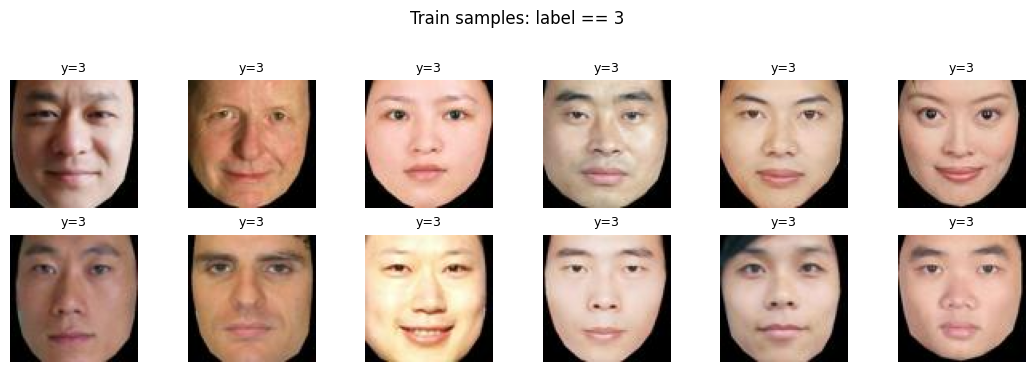

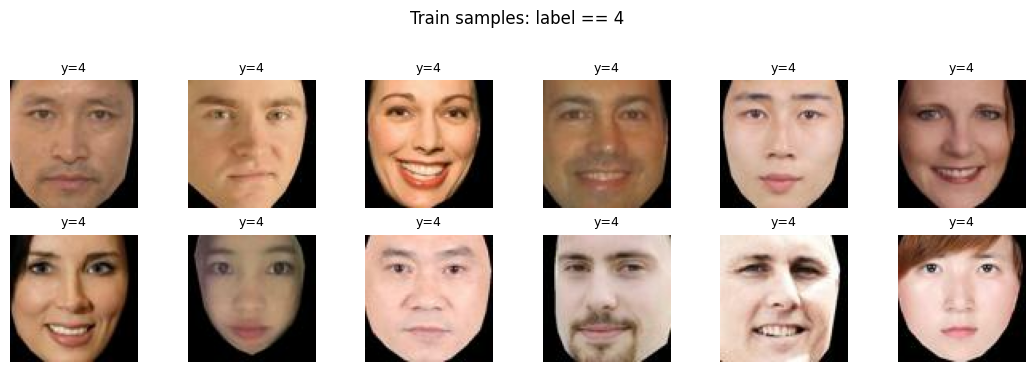

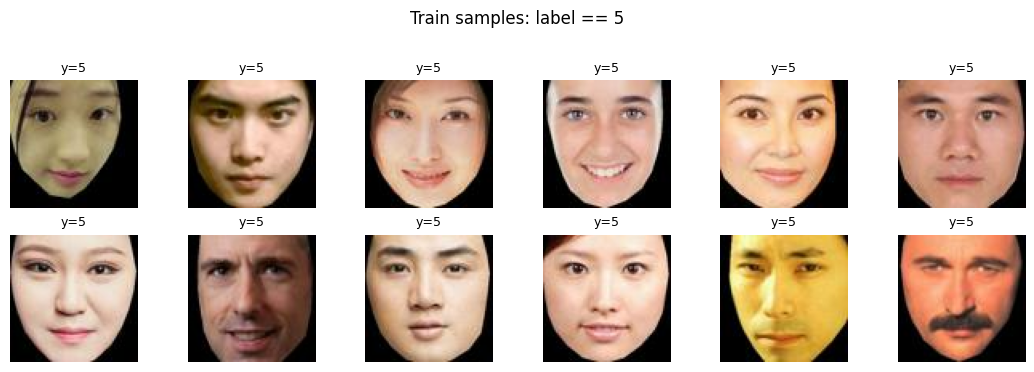

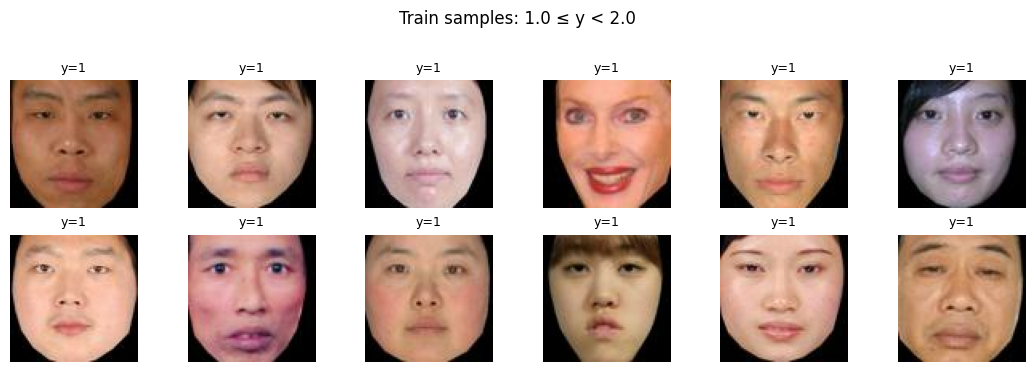

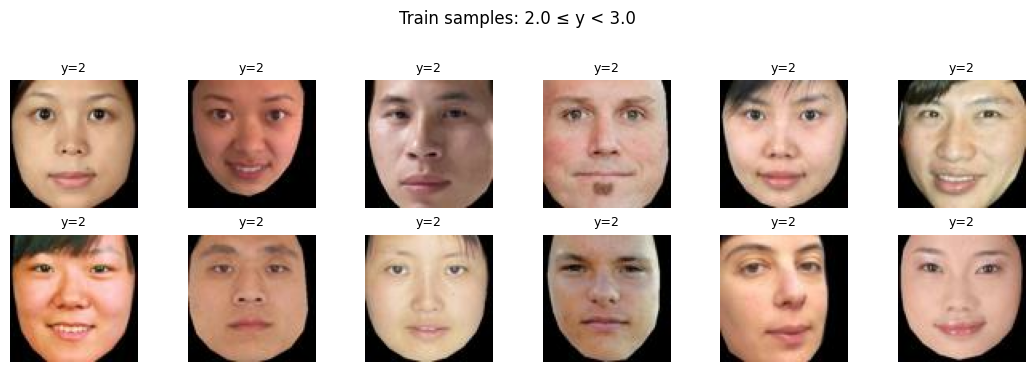

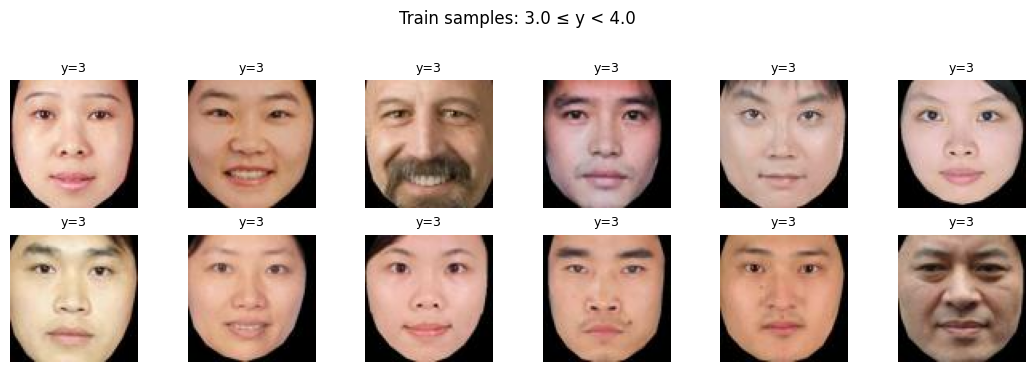

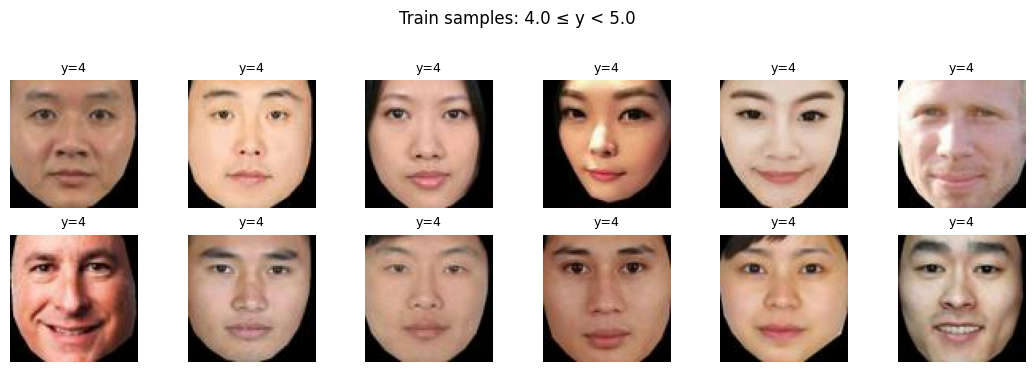

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
def plot_label_histogram(ds, title="Label histogram", bins=None, max_samples=None):
    labels = []
    n = 0
    for _, y in ds:
        y = tf.reshape(y, []).numpy().item()  # scalar
        labels.append(y)
        n += 1
        if max_samples is not None and n >= max_samples:
            break

    plt.figure(figsize=(6,4))
    if bins is None:
        # SCUT-FBP5500 labels are integers, usually 1..5. Force integer bins if desired.
        min_l, max_l = int(min(labels)), int(max(labels))
        bins = range(min_l, max_l + 2)  # inclusive edges for integers
    plt.hist(labels, bins=bins, edgecolor="black")
    plt.xlabel("Label"); plt.ylabel("Count"); plt.title(title)
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

# Usage:
plot_label_histogram(train_dataset, title="Train label histogram", max_samples=100000)
plot_label_histogram(validation_dataset, title="Val label histogram")
def _collect_examples(ds, predicate, k):
    """Collect up to k examples (img,y) where predicate(y) is True."""
    bucket = []
    for img, y in ds.shuffle(2048):
        y = tf.reshape(y, []).numpy().item()
        if predicate(y):
            bucket.append((img.numpy(), y))
            if len(bucket) >= k:
                break
    return bucket

def sample_by_label_equal(ds, target_label, k=8):
    """Sample images whose label == target_label (int)."""
    return _collect_examples(ds, lambda y: int(round(y)) == int(target_label), k)

def sample_by_label_range(ds, lo, hi, k=8, inclusive_right=False):
    """Sample images with lo <= y < hi  (or <= hi if inclusive_right)."""
    if inclusive_right:
        return _collect_examples(ds, lambda y: (y >= lo) and (y <= hi), k)
    return _collect_examples(ds, lambda y: (y >= lo) and (y < hi), k)

def show_grid(examples, title="", cols=8):
    if not examples:
        print("No examples to show.")
        return
    imgs = [e[0] for e in examples]
    ys   = [e[1] for e in examples]
    rows = int(np.ceil(len(imgs)/cols))
    plt.figure(figsize=(1.8*cols, 1.8*rows))
    for i, (im, y) in enumerate(zip(imgs, ys)):
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(np.clip(im, 0, 1))
        ax.set_title(f"y={int(round(y))}", fontsize=9)
        ax.axis("off")
    plt.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()
for L in [1, 2, 3, 4, 5]:
    exs = sample_by_label_equal(train_dataset, L, k=12)
    show_grid(exs, title=f"Train samples: label == {L}", cols=6)
bins = [(1.0,2.0), (2.0,3.0), (3.0,4.0), (4.0,5.0)]
for lo, hi in bins:
    exs = sample_by_label_range(train_dataset, lo, hi, k=12)
    show_grid(exs, title=f"Train samples: {lo} ≤ y < {hi}", cols=6)


# Model Creation

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
  plt.figure()
  plt.plot(history.history["loss"], label="train")
  plt.plot(history.history.get("val_loss", []), label="val")
  plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True)
  plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers as L, Model, callbacks

class SingleBar(callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.pbar = tqdm(
            total=self.params['epochs'],
            desc='training',
            leave=False,              # keeps it to a single rolling line
            dynamic_ncols=True,
            bar_format='{l_bar}{bar} {n_fmt}/{total_fmt} [{elapsed}<{remaining}] {postfix}'
        )

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        tail = {k: f"{logs[k]:.4f}" for k in ("loss","mse","rounded_mae") if k in logs}
        # 1) set postfix WITHOUT forcing an immediate refresh
        self.pbar.set_postfix(tail, refresh=False)
        # 2) now advance the bar (this triggers a single refresh)
        self.pbar.update(1)

    def on_train_end(self, logs=None):
        self.pbar.close()

class AttractRegressorModel(Model):
    def __init__(self, architecture:dict):
        super().__init__()
        self.architecture = architecture
        self.layer_list = self._build_model(architecture)
        self.is_sequential = self.architecture.get("computation_sequence", "sequential") == "sequential"
        if self.is_sequential:
          self.layer_list = tf.keras.Sequential(self.layer_list)
        #for residuality
        self.residual_map = {}
        self.required_outputs = set()
        if not self.is_sequential:
            self._parse_computation_sequence()

    def _parse_computation_sequence(self, architecture):
        computation_sequence = self.architecture.get("computation_sequence")
        for conn_str in computation_sequence:
            try:
                start, end = map(int, conn_str.split('-'))
                if start >= end:
                    raise ValueError(f"Start index ({start}) must be less than end index ({end}) in connection '{conn_str}'.")

                # Map the end point to the start point for quick lookups
                self.residual_map[end] = start

                # We need to store the output of the layer *before* the start index
                self.required_outputs.add(start - 1)
                print(f"  - Will add output of layer {start - 1} to output of layer {end}")

            except ValueError as e:
                raise ValueError(f"Invalid connection format: '{conn_str}'. Expected 'start-end'. Details: {e}")

    def _build_cnn_layer(self,params):
      return L.Conv2D(
            filters=params["out_channels"],
            kernel_size=params.get("kernel_size", 3),
            padding=params.get("padding", "same"),
            kernel_initializer=params.get("initialization", "he_normal"),
            use_bias=params.get("use_bias", True)
        ) if "dilation" not in params else L.Conv2D(
            filters=params["out_channels"],
            kernel_size=params.get("kernel_size", 3),
            padding=params.get("padding", "same"),
            dilation_rate=params.get("dilation", 1),
            kernel_regularizer=tf.keras.regularizers.l2(params.get("l2_rate", 0)),
            use_bias=params.get("use_bias", True)
        )

    def _build_maxpool_layer(self,params):
      return L.MaxPooling2D(
            pool_size=params.get("pool_size", 2),
            strides=params.get("strides", 2)
        )

    def _build_batchnorm_layer(self,layer):
      return L.BatchNormalization()

    def _build_activation_layer(self, params: dict):
        name = params.get("name", "relu").lower()
        if name == 'leakyrelu':
            return L.LeakyReLU(alpha=params.get("alpha", 0.1))
        return L.Activation(name)

    def _build_dropout_layer(self, params):
      return L.Dropout(rate=params.get("rate", 0.5))

    def _build_last_layer(self, params: dict):
      """
      Builds the final block of the network (the head).
      This can be a multi-layer sequence, so it returns a Sequential model.
      """
      head_type = params.get("head_type", "mlp") # Default to mlp
      drop = float(params.get("dropout_rate", 0.0) or 0.0)
      if head_type == "mlp":
        print("  - Building MLP Head (Flatten -> Dense [+ optional Dropout])")
        layers = [
            L.Flatten(),
            L.Dense(2048),
        ]
        if drop > 0:
            layers.append(L.Dropout(drop))
        layers += [
            L.Dense(2048),
        ]
        if drop > 0:
            layers.append(L.Dropout(drop))
        layers += [
            L.Dense(1)
        ]
        return tf.keras.Sequential(layers)

      elif head_type == "fully_convolutional":

        print("  - Building FCN Head (GlobalAvgPool -> Dense)")
        layers = [
            L.GlobalAveragePooling2D(),
            L.Dense(512, activation="relu"),
        ]
        if drop > 0:
          layers.append(L.Dropout(drop))
        layers.append(L.Dense(1))
        return tf.keras.Sequential(layers)
      else:
        raise ValueError(f"Unknown last_layer head_type: {head_type}")

    def _build_model(self,architecture):
      modules = []
      build_maps = {
          "cnn": self._build_cnn_layer,
          "maxpool": self._build_maxpool_layer,
          "batchnorm": self._build_batchnorm_layer,
          "activation": self._build_activation_layer,
          "last_layer": self._build_last_layer,
          "dropout": self._build_dropout_layer
      }
      for module in architecture["layers"]:
          if module["type"] == "noop":
            continue
          build_function = build_maps[module["type"]]
          layer = build_function(module)
          modules.append(layer)
      return modules

    def call(self, inputs, training=False):
        # Sequential Operations
        if self.is_sequential:
            return self.layer_list(inputs, training=training)

        # If there are skip connections:
        outputs_cache = {}
        x = inputs
        # Check if the initial input tensor needs to be stored for a connection
        if 0 in self.required_outputs:
            outputs_cache[0] = x

        # --- Main Forward Pass with Inline Additions ---
        for i, layer in enumerate(self.layer_list): ## even though Activations are not a layer we treated as it is.
            layer_num = i + 1

            # Forward passing
            x = layer(x, training=training)

            # If this layer is an endpoint for a residual connection, perform the addition
            if layer_num in self.residual_map:
                start_idx = self.residual_map[layer_num]

                if (start_idx - 1) not in outputs_cache:
                    raise RuntimeError(f"Logic error: Required output from layer {start_idx - 1} was not cached.")

                shortcut_path = outputs_cache[start_idx - 1]

                # --- Shape Validation ---
                if x.shape[1:] != shortcut_path.shape[1:]:
                    raise ValueError(
                        f"Shape mismatch for residual connection {start_idx}-{layer_num}. "
                        f"Cannot add shortcut shape {shortcut_path.shape} to main shape {x.shape}. "
                        "You may need a projection layer (1x1 Conv) to match dimensions."
                    )

                # Perform the addition, which now becomes the main path tensor 'x'
                x = L.Add()([x, shortcut_path])

            # Check if the activation output is the residual for feature
            if layer_num in self.required_outputs:
                outputs_cache[layer_num] = x

        return x

In [ ]:

# ====== plotting: train + val ======
import matplotlib.pyplot as plt

def plot_train_val_history(hist, title="Training"):
    e = range(1, len(hist["loss"])+1)

    plt.figure(figsize=(13,6))

    # Loss (MSE loss)
    plt.subplot(1,2,1)
    plt.plot(e, hist["loss"], label="train loss")
    if "val_loss" in hist: plt.plot(e, hist["val_loss"], label="val loss")
    plt.xlabel("epoch"); plt.ylabel("MSE loss"); plt.title("Loss"); plt.grid(True, alpha=0.3); plt.legend()

    # MAE (rounded)
    plt.subplot(1,2,2)
    # If you also log unrounded MAE, you can plot it too; here we focus on rounded MAE per the assignment
    if "rounded_mae" in hist:       plt.plot(e, hist["rounded_mae"], label="train rMAE")
    if "val_rounded_mae" in hist:   plt.plot(e, hist["val_rounded_mae"], label="val rMAE")
    # (optionally show unrounded)
    if "mean_absolute_error" in hist:        plt.plot(e, hist["mean_absolute_error"], '--', alpha=0.5, label="train MAE")
    if "val_mean_absolute_error" in hist:    plt.plot(e, hist["val_mean_absolute_error"], '--', alpha=0.5, label="val MAE")

    plt.xlabel("epoch"); plt.ylabel("MAE"); plt.title("MAE"); plt.grid(True, alpha=0.3); plt.legend()
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def prepare_train(ds, batch_size=32, seed=1337):
    return (ds
            .shuffle(8192, seed=seed, reshuffle_each_iteration=True)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE))

# Useful utility tool for adding l2 regularization to layers
def add_l2_to_layers(layers, l2_rate=1e-4):
    for layer in layers:
        if layer["type"] in ["cnn", "last_layer"]:
            layer["l2_rate"] = l2_rate
    return layers

def prepare_val(ds, batch_size=32):
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
from IPython.display import clear_output

class LivePlot(callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.h = {"loss":[], "val_loss":[], "mean_absolute_error":[], "val_mean_absolute_error":[]}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for k in self.h.keys():
            if k in logs: self.h[k].append(logs[k])
        clear_output(wait=True)
        e = range(1, len(self.h["loss"])+1)
        plt.figure(figsize=(13,6))
        # Loss
        plt.subplot(1,2,1)
        plt.plot(e, self.h["loss"], label="train loss")
        if self.h["val_loss"]: plt.plot(e, self.h["val_loss"], label="val loss")
        plt.title("Loss"); plt.grid(True, alpha=0.3); plt.legend()
        # MAE
        plt.subplot(1,2,2)
        if self.h["mean_absolute_error"]: plt.plot(e, self.h["mean_absolute_error"], '--', label="train MAE")
        if self.h["val_mean_absolute_error"]: plt.plot(e, self.h["val_mean_absolute_error"], '--', label="val MAE")
        plt.title("MAE"); plt.grid(True, alpha=0.3); plt.legend()
        plt.tight_layout(); plt.show()
def train_with_val(model,
                   train_ds_full,
                   val_ds_full,
                   epochs=100,
                   batch_size=32,
                   lr=1e-3,
                   name="model",
                   early_stop=True):
    train_ds = prepare_train(train_ds_full, batch_size=batch_size)
    val_ds   = prepare_val(val_ds_full, batch_size=batch_size)

    # Build once (subclassed model)
    x0, _ = next(iter(train_ds))
    _ = model(x0, training=True)

    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(
        optimizer=opt, loss="mse",
        metrics=[
            tf.keras.metrics.MeanSquaredError(name="mse"),
            tf.keras.metrics.MeanAbsoluteError(name="mean_absolute_error"),
        ]
    )

    for layer in model.layers:
      if hasattr(layer, 'kernel_regularizer') and layer.kernel_regularizer:
        print(f"{layer.name}: L2 = {layer.kernel_regularizer.l2}")


    cbs = [LivePlot(),SingleBar(), callbacks.TerminateOnNaN()]
    if early_stop:
        cbs += [
            callbacks.ReduceLROnPlateau(monitor="val_mean_absolute_error", factor=0.5, patience=10, min_lr=1e-6, verbose=1, mode='min'),
            callbacks.EarlyStopping(monitor="val_mean_absolute_error", patience=20, restore_best_weights=True, verbose=1, mode='min'),
        ]

    print(f"\n[train] {name} | lr={lr} | bs={batch_size} | epochs={epochs}")
    h = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        verbose=0,                 # SingleBar drives the progress
        callbacks=cbs
    ).history
    print(h["val_loss"])
    # summary
    last_idx = len(h["loss"]) - 1
    best_idx = (np.nanargmin(h["val_mean_absolute_error"])
                if "val_mean_absolute_error" in h and len(h["val_mean_absolute_error"]) > 0
                else last_idx)
    last = {
        "epoch": last_idx + 1,
        "loss": h["loss"][last_idx],
        "val_loss": h.get("val_loss", [np.nan])[last_idx],
        "mae": h.get("mean_absolute_error", [np.nan])[last_idx],
        "val_mae": h.get("val_mean_absolute_error", [np.nan])[last_idx],
    }
    best = {
        "epoch": best_idx + 1,
        "loss": h["loss"][best_idx],
        "val_loss": h.get("val_loss", [np.nan])[best_idx],
        "mae": h.get("mean_absolute_error", [np.nan])[best_idx],
        "val_mae": h.get("val_mean_absolute_error", [np.nan])[best_idx],
    }

    print(f"[{name}] LAST @ epoch {last['epoch']}: "
          f"loss={last['loss']:.4f} | val_loss={last['val_loss']:.4f} | "
          f"MAE={last['mae']:.4f} | val_MAE={last['val_mae']:.4f}")

    print(f"[{name}] BEST (val_MAE) @ epoch {best['epoch']}: "
          f"loss={best['loss']:.4f} | val_loss={best['val_loss']:.4f} | "
          f"MAE={best['mae']:.4f} | val_MAE={best['val_mae']:.4f}")

    # plot
    plot_train_val_history(h, title=f"{name} train/val")

    return h

Model Visualization Utils

Building VGG Like Architecture Let's Focus on Max Pooling and Dilations. Which one is better and why?

In [ ]:
from tensorflow.keras import callbacks
from tqdm import tqdm
def add_l2_to_layers(layers, l2_rate=1e-4):
    for layer in layers:
        if layer["type"] in ["cnn", "last_layer"]:
            layer["l2_rate"] = l2_rate
    return layers
def create_vgg_16_configs(use_batch_norm=False,l2_norm = 0, dropout_rate=0, dropout_only_dense = False, cnn_initialization_type="he_normal", fc_init_type="he_normal"):
  use_dropout = dropout_rate > 0
  all_layers_dropout = use_dropout and not dropout_only_dense
  # VGG16 Layers
  if not all_layers_dropout:
    vgg16_layers = [
        # Block 1
        {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "maxpool", "pool_size": 2, "strides": 2},
        # [40,40,64] RF 6
        # Block 2
        {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "maxpool", "pool_size": 2, "strides": 2},
        # [20,20,128] RF 16
        # Block 3
        {"type": "cnn", "out_channels": 256, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 256, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 256, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "maxpool", "pool_size": 2, "strides": 2},
        # [10,10,256] RF 44
        # Block 4
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "maxpool", "pool_size": 2, "strides": 2},
        # [5,5,512] RF 100
        # Block 5
        # In original VGG 16 They have 5 block with RF 220. We have 80x80 image that is more than enough. So we concluded directly with mlp
        {"type": "last_layer", "head_type": "mlp", "dropout_rate": dropout_rate}
        #
    ]
  else:
    vgg16_layers = [
        # Block 1
        {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "maxpool", "pool_size": 2, "strides": 2},
        {"type": "dropout", "rate": 0.1},
        # [40,40,64] RF 6
        # Block 2
        {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "maxpool", "pool_size": 2, "strides": 2},
        {"type": "dropout", "rate": 0.1},
        # [20,20,128] RF 16
        # Block 3
        {"type": "cnn", "out_channels": 256, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 256, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 256, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "maxpool", "pool_size": 2, "strides": 2},
        {"type": "dropout", "rate": 0.1},
        # [10,10,256] RF 44
        # Block 4
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "maxpool", "pool_size": 2, "strides": 2},
        {"type": "dropout", "rate": 0.1},
        # [5,5,512] RF 100
        # Block 5
        # In original VGG 16 They have 5 block with RF 220. We have 80x80 image that is more than enough. So we concluded directly with mlp
        {"type": "last_layer", "head_type": "mlp", "dropout_rate": dropout_rate}
        #
    ]
  if l2_norm > 0:
    add_l2_to_layers(vgg16_layers,l2_norm)
  vgg16_config = {
      "layers": vgg16_layers,
      "computation_sequence": "sequential"
  }
  return vgg16_config
def create_vgg16_dilated_configs(use_batch_norm=False,l2_norm = 0, dropout_rate=0, dropout_only_dense = False, initialization_type="he_normal", remove_bias=False):
  use_dropout = dropout_rate > 0
  all_layers_dropout = use_dropout and not dropout_only_dense
  vgg16_dilated_layers = []
  if not all_layers_dropout:
    vgg16_dilated_layers = [
        # Block 1 (same)
        {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "maxpool", "pool_size": 2, "strides": 2},


        # Block 2 (same)
        {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "maxpool", "pool_size": 2, "strides": 2},


        # Block 4 (dilated; no pool)
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 2, "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 2, "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 2, "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},

        # Block 5 (stronger dilation; no pool)
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 4, "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 4, "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 4, "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "last_layer", "head_type": "fully_convolutional", "dropout_rate": dropout_rate}
    ]
    print(f"Entered here. {vgg16_dilated_layers}")
  else:
    vgg16_dilated_layers = [
        # Block 1 (same)
        {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "maxpool", "pool_size": 2, "strides": 2},
        {"type": "dropout", "rate": 0.1},
        # Block 2 (same)
        {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "maxpool", "pool_size": 2, "strides": 2},
        {"type": "dropout", "rate": 0.1},

        # Block 4 (dilated; no pool)
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 2, "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 2, "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 2, "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "dropout", "rate": 0.1},

        # Block 5 (stronger dilation; no pool)
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 4, "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 4, "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 4, "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "dropout", "rate": 0.1},

        {"type": "last_layer", "head_type": "fully_convolutional","dropout_rate": dropout_rate}
    ]
  print(vgg16_dilated_layers)
  if l2_norm > 0:
    add_l2_to_layers(vgg16_dilated_layers,l2_norm)
  vgg16_config = {
      "layers": vgg16_dilated_layers,
      "computation_sequence": "sequential"
  }
  vgg_dilated_layers_config = {
      "layers": vgg16_dilated_layers,
      "computation_sequence": "sequential"
  }
  return vgg_dilated_layers_config

def build_model(vgg_model_config):
  vgg_model = AttractRegressorModel(vgg_model_config)
  return vgg_model


# Now running configurations

In [ ]:
general_learning_rate = 3e-4
general_batch_size = 8
general_epochs= 70

Default model

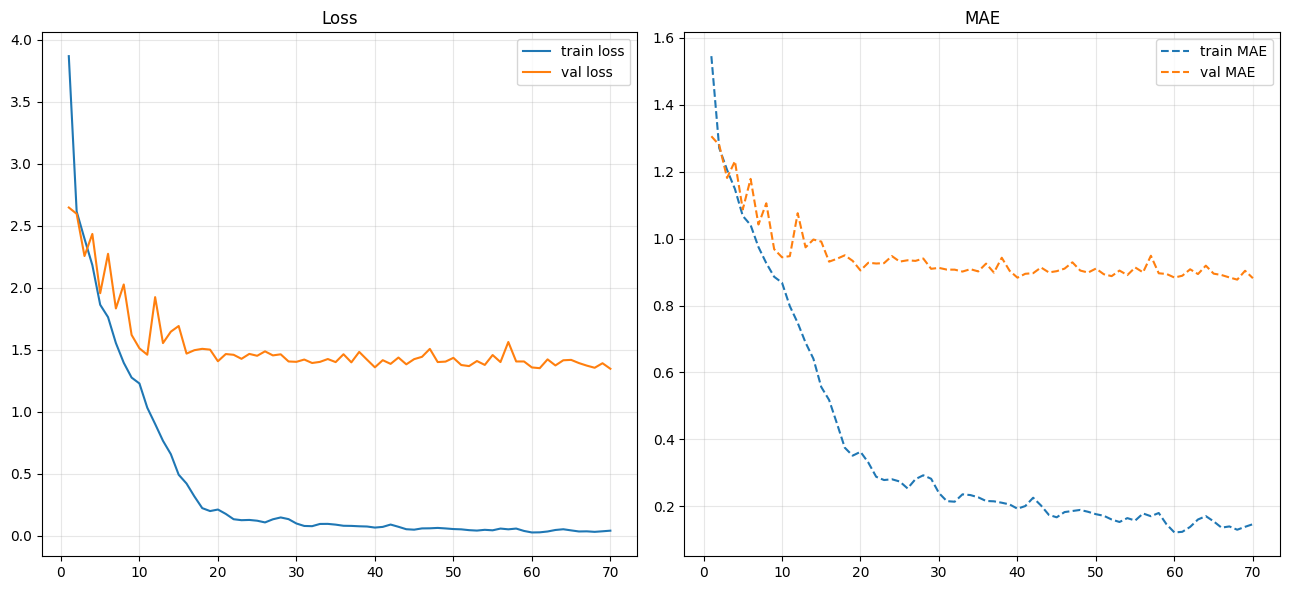


training: 100%|██████████ 70/70 [07:50<00:00] , loss=0.0408, mse=0.0408
                                                                       

[2.6458933353424072, 2.5951123237609863, 2.2547731399536133, 2.432861089706421, 1.9550807476043701, 2.272862195968628, 1.832173228263855, 2.0254933834075928, 1.6189805269241333, 1.510553002357483, 1.4592276811599731, 1.9233490228652954, 1.5528850555419922, 1.6450430154800415, 1.690600872039795, 1.4681968688964844, 1.4956598281860352, 1.5066559314727783, 1.500235676765442, 1.4066007137298584, 1.4646520614624023, 1.4585975408554077, 1.4261592626571655, 1.4657717943191528, 1.4505746364593506, 1.4863865375518799, 1.4537378549575806, 1.462512493133545, 1.4047882556915283, 1.4018895626068115, 1.4202791452407837, 1.3924580812454224, 1.4014900922775269, 1.4244321584701538, 1.3996535539627075, 1.4630435705184937, 1.3975776433944702, 1.481877088546753, 1.4188717603683472, 1.3575512170791626, 1.4151118993759155, 1.3853070735931396, 1.4364559650421143, 1.381762146949768, 1.423525094985962, 1.4421780109405518, 1.5062620639801025, 1.40005624294281, 1.4036812782287598, 1.4339267015457153, 1.376182317

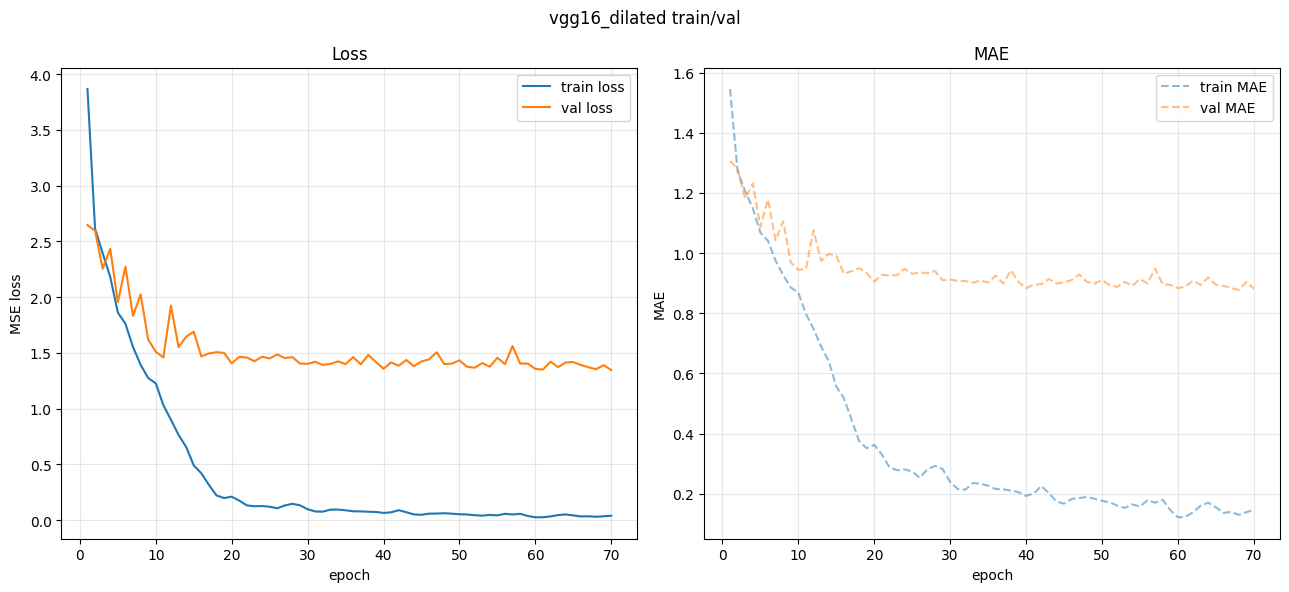

In [ ]:
general_learning_rate = 3e-4
general_batch_size = 8
general_epochs= 70
dilated_vgg= build_model(create_vgg16_dilated_configs())
_ = train_with_val(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16_dilated",early_stop=False
)



Default + Early stopping and reduce lr on plateau

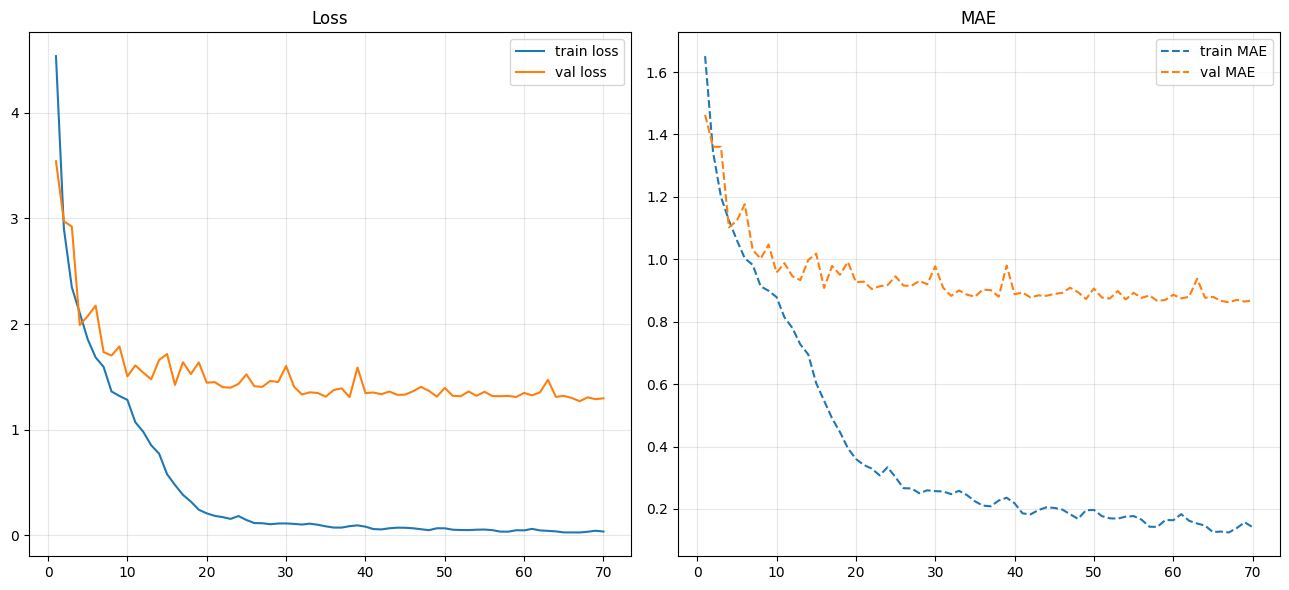


training: 100%|██████████ 70/70 [07:52<00:00] , loss=0.0371, mse=0.0371
                                                                       

Restoring model weights from the end of the best epoch: 67.
[3.541994094848633, 2.9732706546783447, 2.9231481552124023, 1.9917361736297607, 2.075787305831909, 2.175382614135742, 1.7357640266418457, 1.702943205833435, 1.7890933752059937, 1.5056495666503906, 1.6096062660217285, 1.5409207344055176, 1.4778286218643188, 1.6611716747283936, 1.7171885967254639, 1.425045371055603, 1.6394752264022827, 1.5276905298233032, 1.6375442743301392, 1.4458438158035278, 1.4514665603637695, 1.4039583206176758, 1.3985618352890015, 1.4345329999923706, 1.5248147249221802, 1.4124600887298584, 1.4062906503677368, 1.4624013900756836, 1.4525537490844727, 1.6037243604660034, 1.4081454277038574, 1.3346811532974243, 1.3549695014953613, 1.3479926586151123, 1.3133314847946167, 1.3768885135650635, 1.3922715187072754, 1.3092361688613892, 1.589167833328247, 1.3476072549819946, 1.3529375791549683, 1.3368974924087524, 1.362529993057251, 1.331105351448059, 1.332942008972168, 1.3649342060089111, 1.4064754247665405, 1.368716

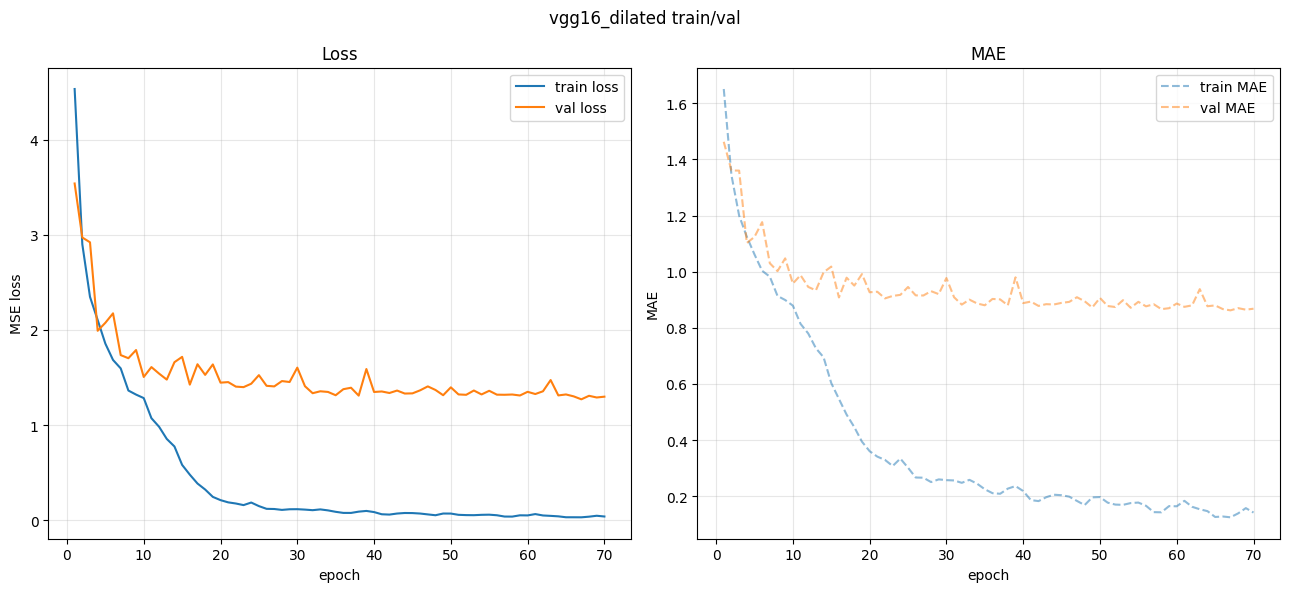

In [ ]:
del dilated_vgg

dilated_vgg= build_model(create_vgg16_dilated_configs())
_ = train_with_val(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16_dilated",early_stop=True
)

Batch norm added

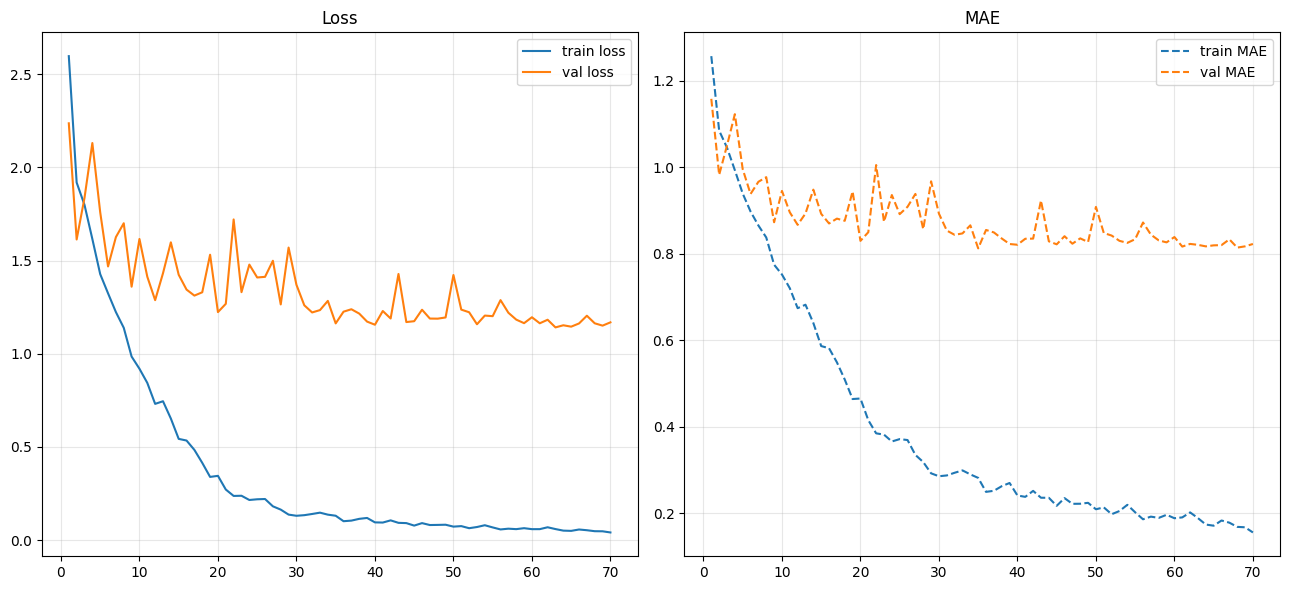


training: 100%|██████████ 70/70 [11:07<00:00] , loss=0.0405, mse=0.0405
                                                                       

[2.2369275093078613, 1.6133452653884888, 1.8367571830749512, 2.1309947967529297, 1.7594976425170898, 1.468425989151001, 1.6261389255523682, 1.7004526853561401, 1.359885334968567, 1.6160567998886108, 1.4134677648544312, 1.2876293659210205, 1.4320988655090332, 1.5979864597320557, 1.423819661140442, 1.344214916229248, 1.3120267391204834, 1.3298250436782837, 1.5315611362457275, 1.2234163284301758, 1.2678765058517456, 1.7208738327026367, 1.3304400444030762, 1.478473424911499, 1.409325122833252, 1.4127206802368164, 1.4990520477294922, 1.2647433280944824, 1.5699676275253296, 1.370136022567749, 1.2600361108779907, 1.2215691804885864, 1.2342333793640137, 1.2836731672286987, 1.1628448963165283, 1.2257230281829834, 1.2387694120407104, 1.2154580354690552, 1.1724097728729248, 1.1556650400161743, 1.2293028831481934, 1.1891322135925293, 1.428062081336975, 1.1699899435043335, 1.1745785474777222, 1.236209511756897, 1.1887801885604858, 1.188240885734558, 1.1947133541107178, 1.4225902557373047, 1.2367748

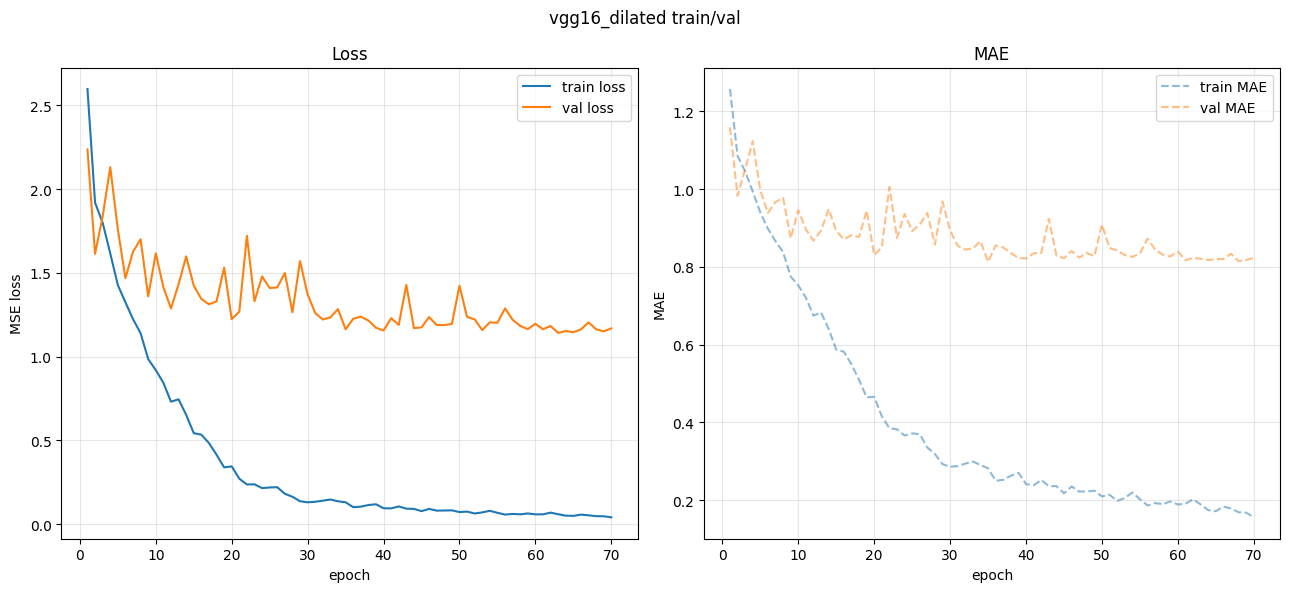

In [ ]:
del dilated_vgg

dilated_vgg= build_model(create_vgg16_dilated_configs(use_batch_norm=True))
_ = train_with_val(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16_dilated",early_stop=False
)

Batchnorm + L2

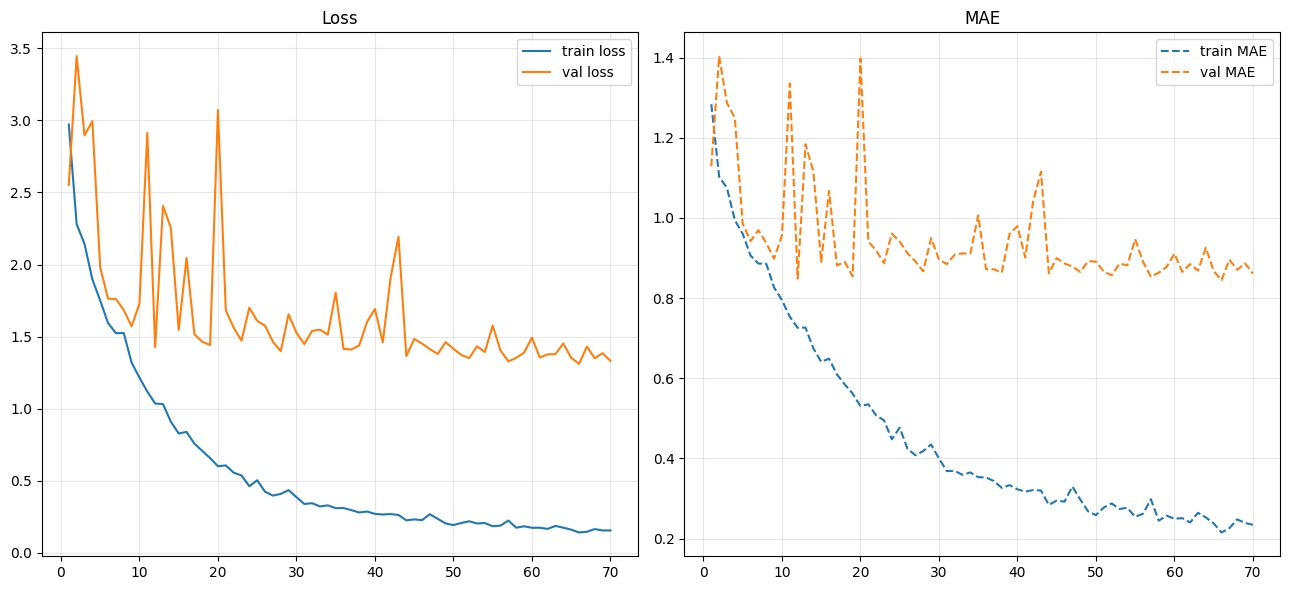


training: 100%|██████████ 70/70 [11:07<00:00] , loss=0.1557, mse=0.0938
                                                                       

[2.5529091358184814, 3.445829153060913, 2.8960232734680176, 2.995124101638794, 1.9802775382995605, 1.7633863687515259, 1.76107919216156, 1.6845146417617798, 1.571937918663025, 1.7284517288208008, 2.915144681930542, 1.427176833152771, 2.4069952964782715, 2.254990816116333, 1.5472227334976196, 2.0467920303344727, 1.5168371200561523, 1.4644737243652344, 1.4420381784439087, 3.0718014240264893, 1.6829144954681396, 1.5626953840255737, 1.4719033241271973, 1.7013505697250366, 1.6094896793365479, 1.5759183168411255, 1.4649091958999634, 1.3992856740951538, 1.6547173261642456, 1.5269593000411987, 1.4481099843978882, 1.5399712324142456, 1.548429012298584, 1.5140461921691895, 1.8049445152282715, 1.4149000644683838, 1.4106348752975464, 1.439360499382019, 1.603067398071289, 1.691688895225525, 1.4602540731430054, 1.9105381965637207, 2.1924214363098145, 1.3649845123291016, 1.4842281341552734, 1.451429843902588, 1.4133367538452148, 1.380162000656128, 1.4616856575012207, 1.4162801504135132, 1.37268924713

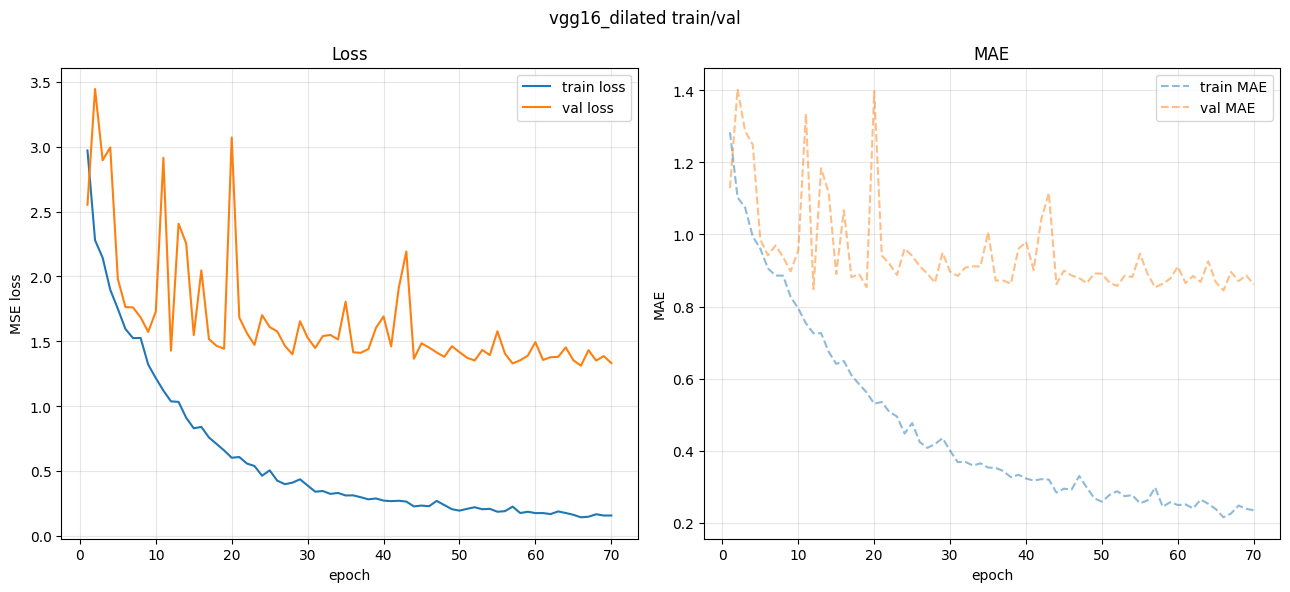

In [ ]:
del dilated_vgg

dilated_vgg= build_model(create_vgg16_dilated_configs(use_batch_norm=True, l2_norm=1e-4))
_ = train_with_val(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16_dilated",early_stop=False
)

Batchnorm + Early stopping + reducelr on valdiation plateau

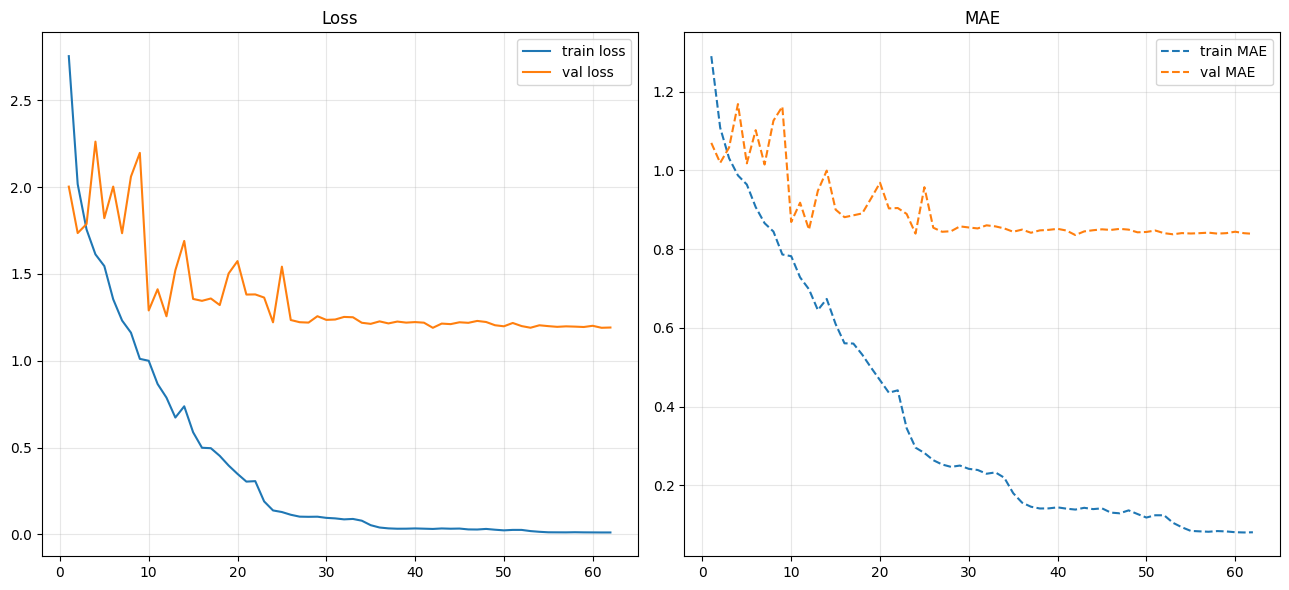


training:  89%|████████▊  62/70 [09:56<01:15] , loss=0.0107, mse=0.0107


Epoch 62: ReduceLROnPlateau reducing learning rate to 1.8750000890577212e-05.


Epoch 62: early stopping
Restoring model weights from the end of the best epoch: 42.
[2.0033206939697266, 1.7357245683670044, 1.7878119945526123, 2.26265287399292, 1.8217103481292725, 2.003577947616577, 1.734710454940796, 2.0611252784729004, 2.197843551635742, 1.2898696660995483, 1.411903738975525, 1.2562988996505737, 1.5212939977645874, 1.6904250383377075, 1.3561464548110962, 1.3452425003051758, 1.3587992191314697, 1.3209339380264282, 1.5028409957885742, 1.5742168426513672, 1.3814998865127563, 1.3821994066238403, 1.3641886711120605, 1.2214601039886475, 1.5420856475830078, 1.234801173210144, 1.222070336341858, 1.219918131828308, 1.2566653490066528, 1.2355148792266846, 1.2376272678375244, 1.252530813217163, 1.2506612539291382, 1.218881607055664, 1.2126396894454956, 1.2268975973129272, 1.2151782512664795, 1.2258511781692505, 1.2197333574295044, 1.2228115797042847, 1.2193602323532104, 1.1899404525756836, 1.2141727209091187, 1.211053729057312, 1.2217037677764893, 1.2185769081115723, 1.2294

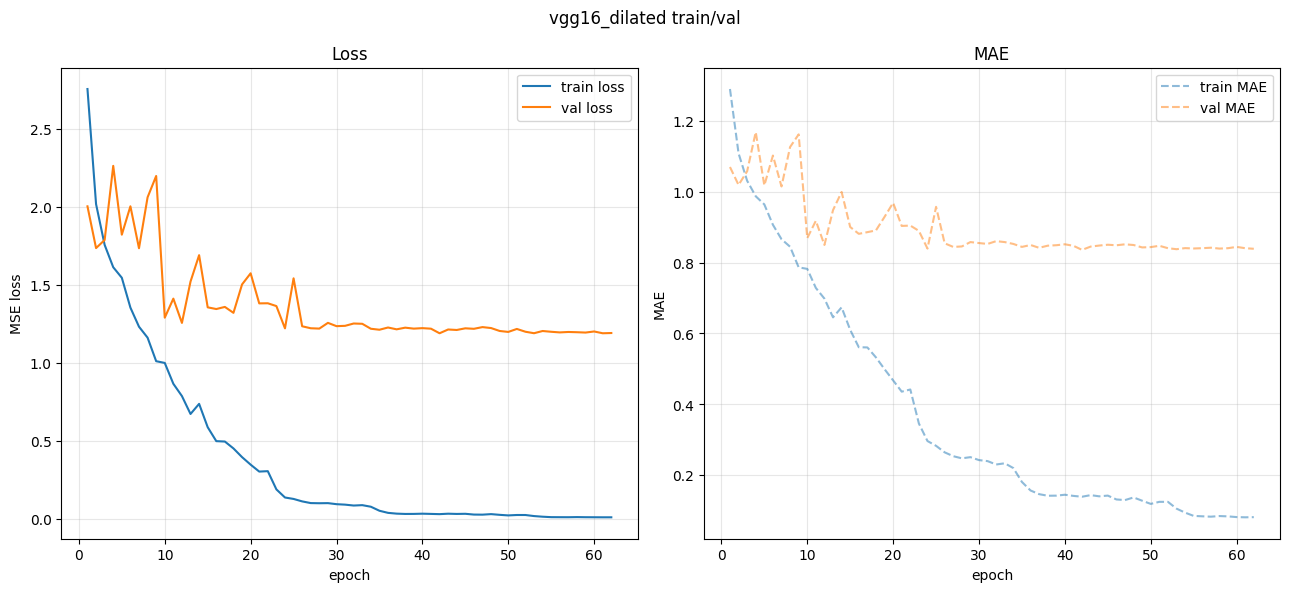

In [ ]:
del dilated_vgg

dilated_vgg= build_model(create_vgg16_dilated_configs(use_batch_norm=True))
_ = train_with_val(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16_dilated",early_stop=True
)

Batchnorm + L2 + early stop + reduce lr on plateau

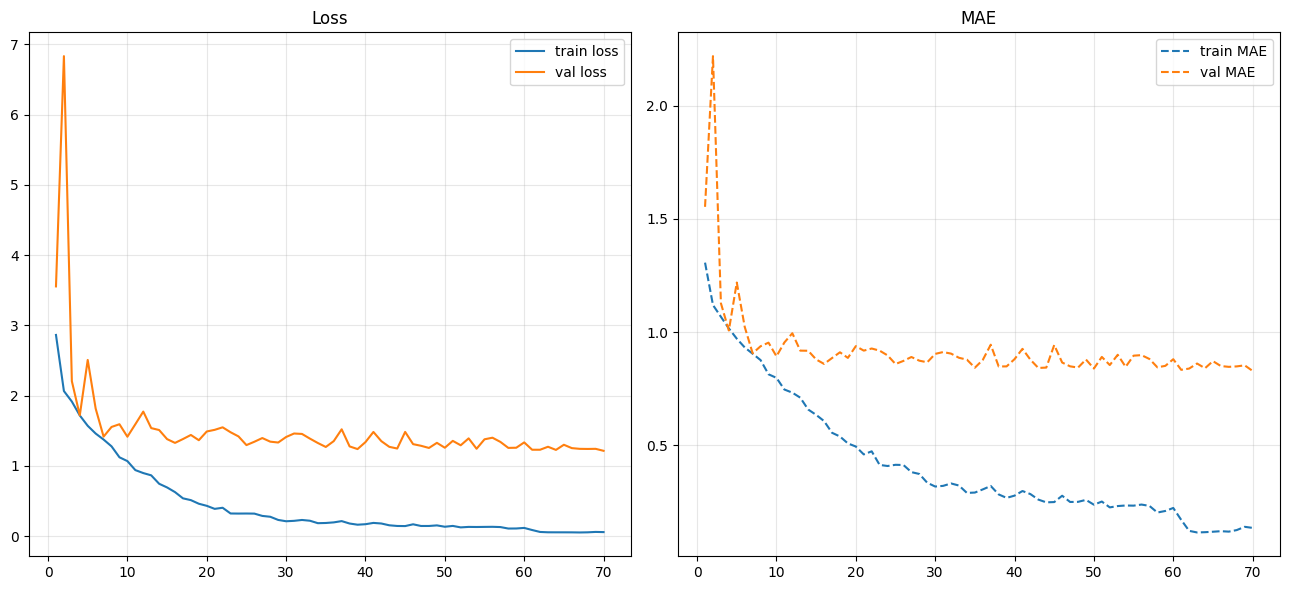



training: 100%|██████████ 70/70 [11:11<00:00] , loss=0.0576, mse=0.0307

                                                                       

Restoring model weights from the end of the best epoch: 70.
[3.555795192718506, 6.8341064453125, 2.2068889141082764, 1.7195885181427002, 2.508568525314331, 1.8167377710342407, 1.41697359085083, 1.5546561479568481, 1.5933122634887695, 1.4154484272003174, 1.5932773351669312, 1.7733957767486572, 1.5383269786834717, 1.5108193159103394, 1.3816463947296143, 1.3276935815811157, 1.3824148178100586, 1.4406787157058716, 1.3658995628356934, 1.490118145942688, 1.5136970281600952, 1.5494601726531982, 1.4792789220809937, 1.4199016094207764, 1.2962911128997803, 1.3441040515899658, 1.3967334032058716, 1.345324158668518, 1.3329824209213257, 1.4117050170898438, 1.4612754583358765, 1.4552395343780518, 1.3885438442230225, 1.3259567022323608, 1.2696995735168457, 1.3529266119003296, 1.52118980884552, 1.2776676416397095, 1.2396836280822754, 1.3393378257751465, 1.4835436344146729, 1.3522902727127075, 1.2716906070709229, 1.2473628520965576, 1.48396897315979, 1.3098653554916382, 1.2864829301834106, 1.2556918859

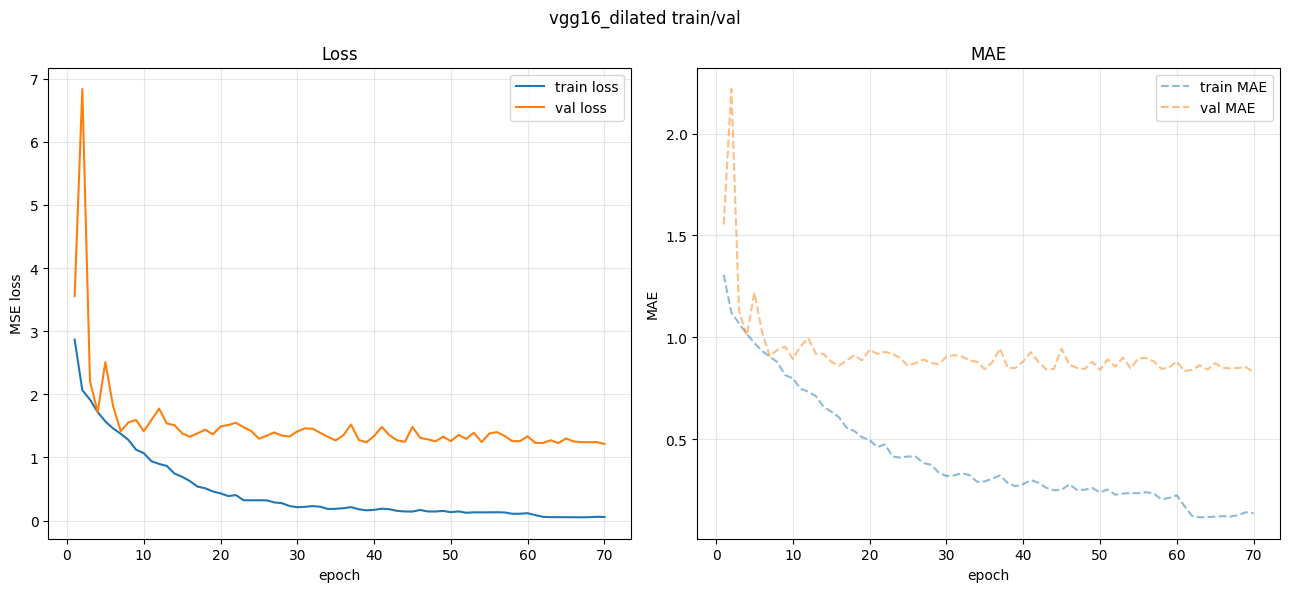

In [ ]:
del dilated_vgg

dilated_vgg= build_model(create_vgg16_dilated_configs(use_batch_norm=True, l2_norm=1e-5))
_ = train_with_val(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16_dilated",early_stop=True
)
del dilated_vgg

# Different Initializations (Xavier /2 or He normal Init vs Xavier Initialization)

Previous runs are made with he normal. Now runing with glorot uniform

Xavier Initialization

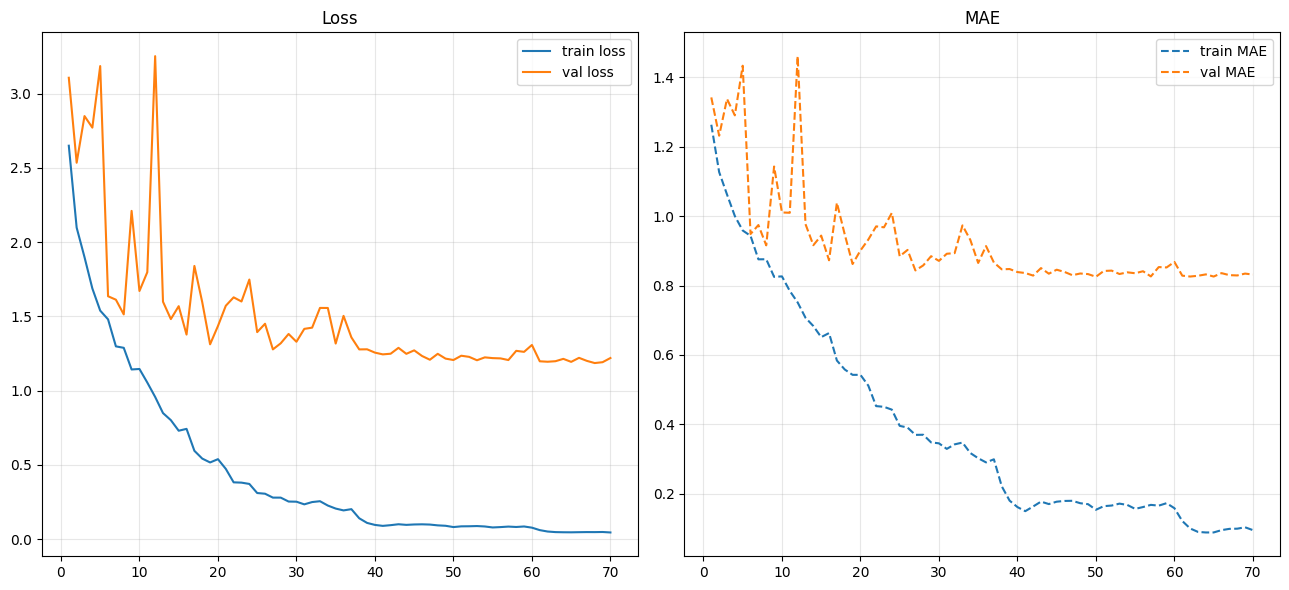

training: 100%|██████████ 70/70 [11:02<00:00] , loss=0.0442, mse=0.0149


Epoch 70: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.


Epoch 70: early stopping
Restoring model weights from the end of the best epoch: 50.


[3.106673002243042, 2.5343616008758545, 2.8485567569732666, 2.770862340927124, 3.1853718757629395, 1.6351287364959717, 1.6118841171264648, 1.5128343105316162, 2.2100632190704346, 1.6704896688461304, 1.7971681356430054, 3.252206802368164, 1.598305106163025, 1.481317400932312, 1.5682486295700073, 1.3769391775131226, 1.8391525745391846, 1.5951400995254517, 1.3114897012710571, 1.4345179796218872, 1.5710105895996094, 1.627769112586975, 1.5998140573501587, 1.747599482536316, 1.3935092687606812, 1.449885368347168, 1.2772256135940552, 1.3183549642562866, 1.3810464143753052, 1.3286210298538208, 1.4154071807861328, 1.4236904382705688, 1.5565043687820435, 1.5561319589614868, 1.3165019750595093, 1.502920389175415, 1.358147382736206, 1.2770967483520508, 1.2777704000473022, 1.2554574012756348, 1.243666172027588, 1.2480356693267822, 1.287643313407898, 1.2473742961883545, 1.2706942558288574, 1.2328221797943115, 1.2075307369232178, 1.2473578453063965, 1.2150635719299316, 1.2056666612625122, 1.234571814

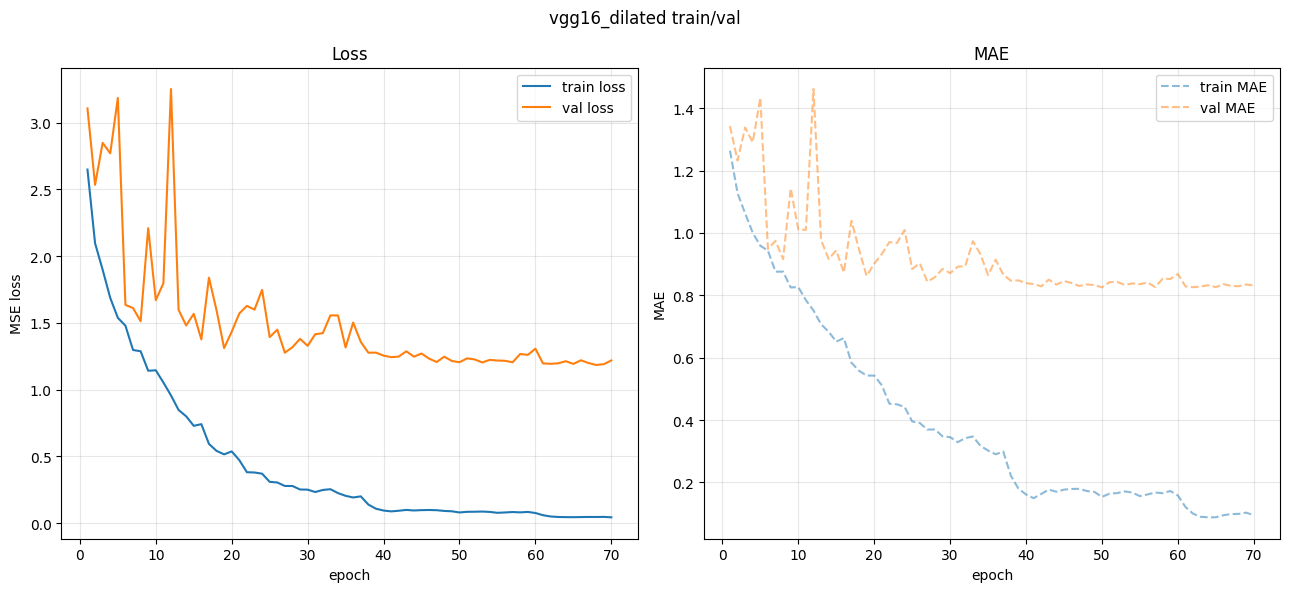

In [ ]:
dilated_vgg= build_model(create_vgg16_dilated_configs(use_batch_norm=True, l2_norm=1e-5, initialization_type="glorot_normal"))
_ = train_with_val(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16_dilated",early_stop=True
)
del dilated_vgg

Random Initialization

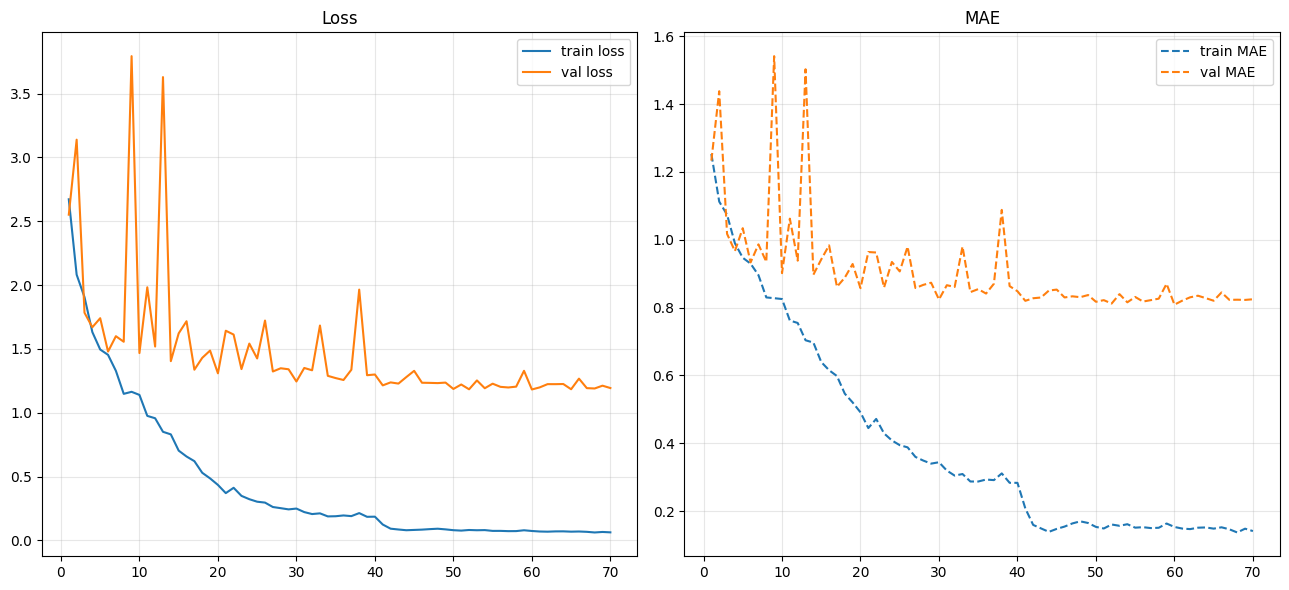

training: 100%|██████████ 70/70 [11:06<00:00] , loss=0.0626, mse=0.0330


Epoch 70: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.


Restoring model weights from the end of the best epoch: 60.


[2.551107406616211, 3.1385786533355713, 1.7832074165344238, 1.6692743301391602, 1.7401317358016968, 1.4787782430648804, 1.5991730690002441, 1.5556443929672241, 3.7929279804229736, 1.4670201539993286, 1.9823404550552368, 1.5180824995040894, 3.6288254261016846, 1.4038227796554565, 1.6214183568954468, 1.7163692712783813, 1.3366575241088867, 1.4293973445892334, 1.4866316318511963, 1.308396816253662, 1.6420032978057861, 1.6119449138641357, 1.3414517641067505, 1.5413179397583008, 1.4248920679092407, 1.7218018770217896, 1.3226622343063354, 1.3480231761932373, 1.340029239654541, 1.244334101676941, 1.350316047668457, 1.3321325778961182, 1.6826436519622803, 1.288666844367981, 1.2710784673690796, 1.2560418844223022, 1.33640456199646, 1.9641152620315552, 1.2934972047805786, 1.299141764640808, 1.2139674425125122, 1.237255573272705, 1.2279407978057861, 1.2787882089614868, 1.327789545059204, 1.2345750331878662, 1.2335044145584106, 1.2317321300506592, 1.2357670068740845, 1.1858806610107422, 1.22082686

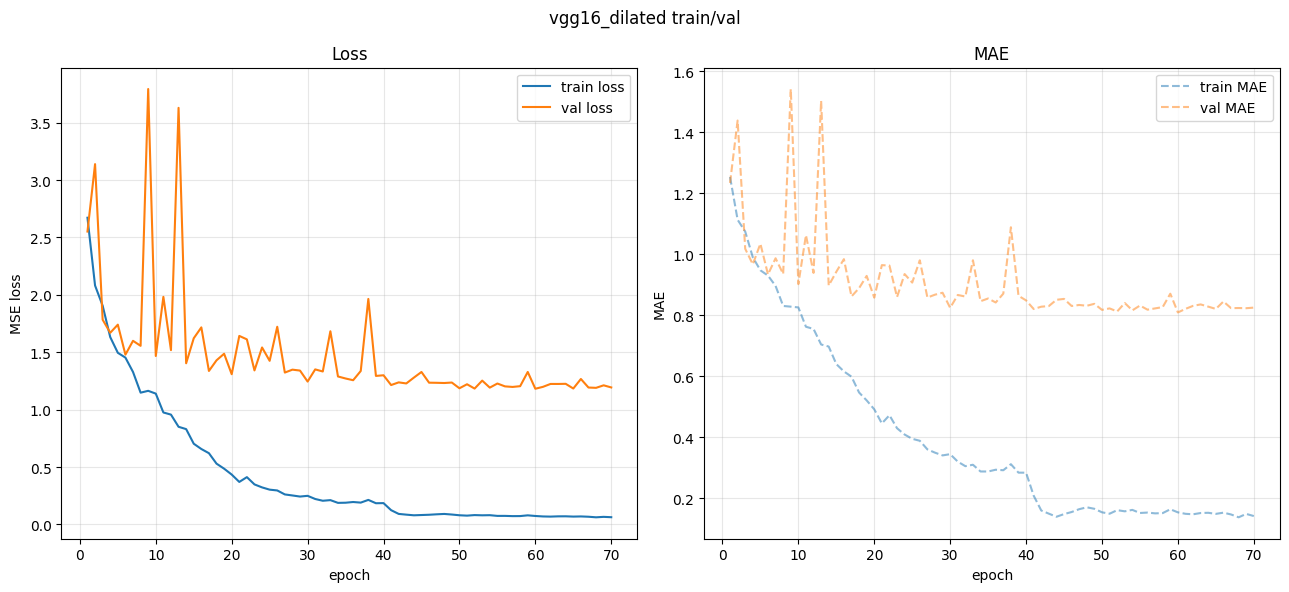

In [ ]:
dilated_vgg= build_model(create_vgg16_dilated_configs(use_batch_norm=True, l2_norm=1e-5, initialization_type="random_normal"))
_ = train_with_val(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16_dilated",early_stop=True
)
del dilated_vgg

# Without Batchnorm
Experiments Without  l2 reg and different initializaitons as batchnorm caused problem

## Xavier (glorot) initialization

In [ ]:
dilated_vgg= build_model(create_vgg16_dilated_configs(use_batch_norm=True, initialization_type="glorot_normal"))
_ = train_with_val(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16_dilated",early_stop=True
)
del dilated_vgg

Dropout

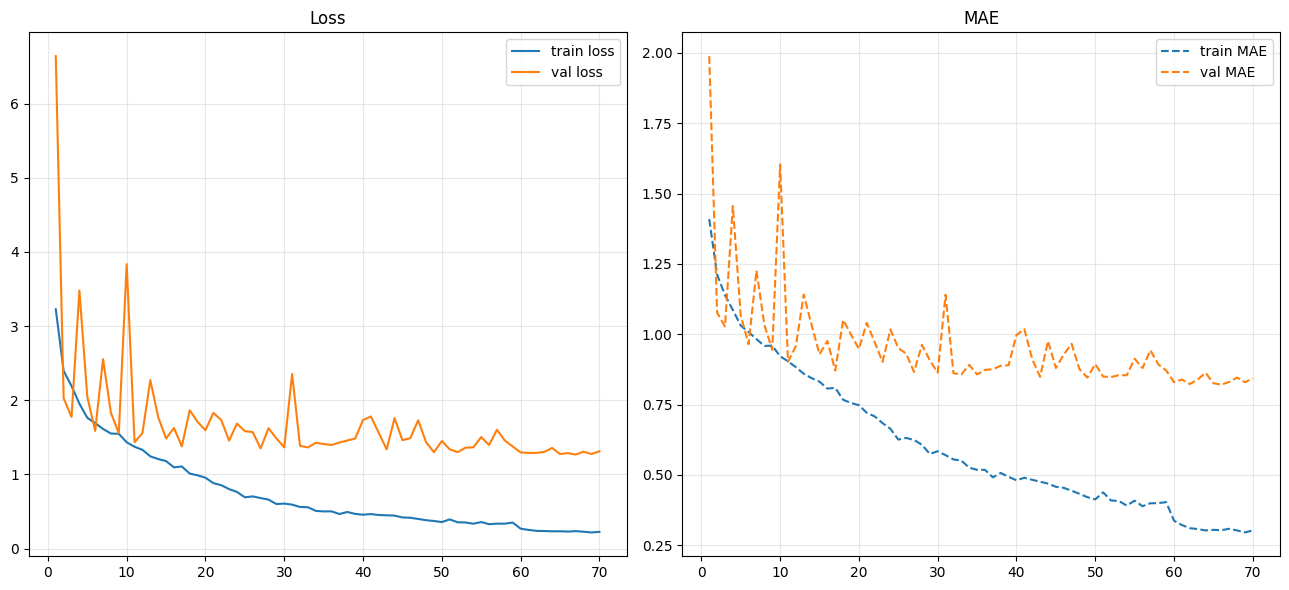

Restoring model weights from the end of the best epoch: 66.


[6.639848709106445, 2.0268046855926514, 1.776649832725525, 3.479736089706421, 2.0478851795196533, 1.5876827239990234, 2.5550827980041504, 1.829954981803894, 1.5575014352798462, 3.8358097076416016, 1.4344863891601562, 1.5587215423583984, 2.2727603912353516, 1.7726606130599976, 1.4858061075210571, 1.6265075206756592, 1.3780897855758667, 1.865746021270752, 1.7090625762939453, 1.5960798263549805, 1.8307907581329346, 1.7338356971740723, 1.4562640190124512, 1.6858272552490234, 1.5835988521575928, 1.571447491645813, 1.3506782054901123, 1.6234636306762695, 1.4876526594161987, 1.3651906251907349, 2.354677438735962, 1.3862717151641846, 1.3640189170837402, 1.4272040128707886, 1.4101104736328125, 1.3971786499023438, 1.430848240852356, 1.457936406135559, 1.483824372291565, 1.7337381839752197, 1.7817180156707764, 1.5600812435150146, 1.3386205434799194, 1.7592990398406982, 1.461718201637268, 1.488999843597412, 1.730067253112793, 1.4364190101623535, 1.2993558645248413, 1.4504611492156982, 1.3398143053

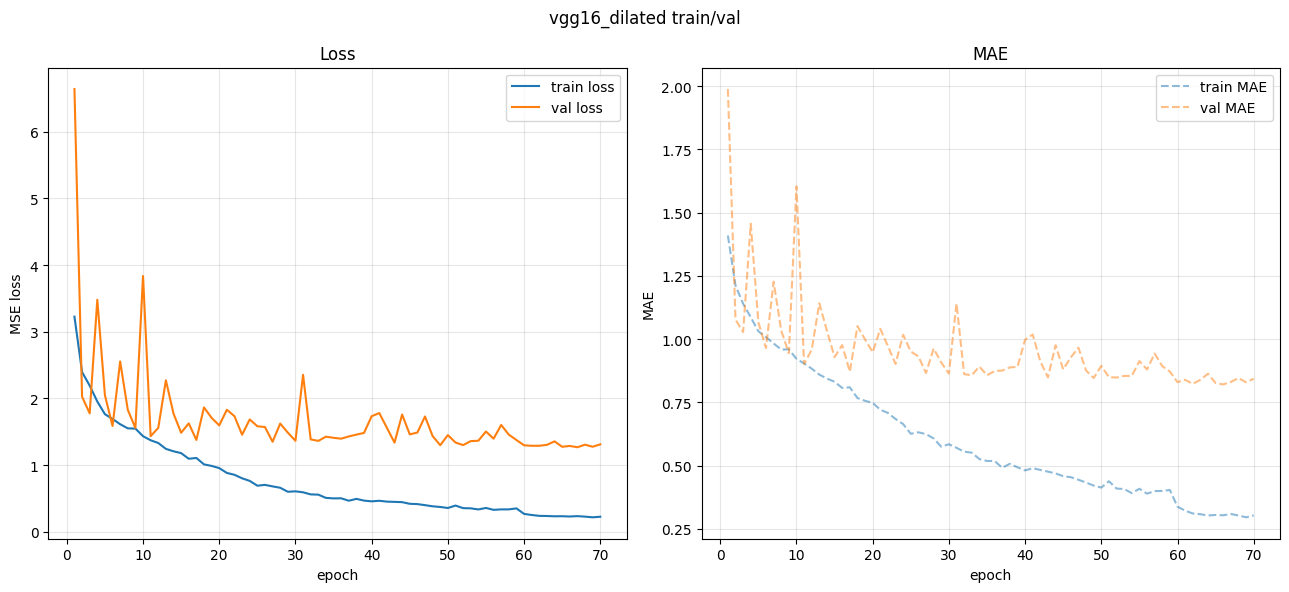

In [ ]:
dilated_vgg= build_model(create_vgg16_dilated_configs(use_batch_norm=True, l2_norm=1e-5, initialization_type="glorot_normal",dropout_only_dense=False,dropout_rate=0.3))
_ = train_with_val(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16_dilated",early_stop=True
)
del dilated_vgg

Dropout only on dense

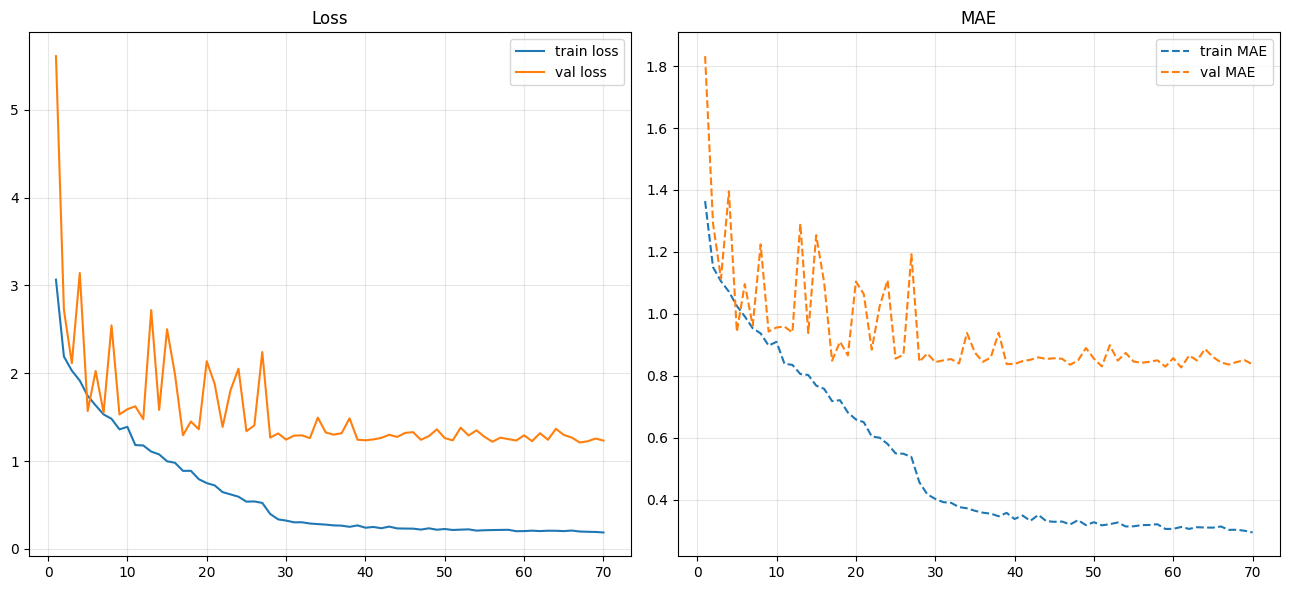

Restoring model weights from the end of the best epoch: 61.


[5.611074447631836, 2.722590923309326, 2.1145377159118652, 3.1426305770874023, 1.570274829864502, 2.0264406204223633, 1.551428198814392, 2.5462241172790527, 1.531574010848999, 1.5908437967300415, 1.6242668628692627, 1.4784173965454102, 2.719243288040161, 1.5825562477111816, 2.5019941329956055, 1.9865590333938599, 1.2943141460418701, 1.4513258934020996, 1.362688422203064, 2.1376349925994873, 1.8782107830047607, 1.3897790908813477, 1.8080368041992188, 2.052020311355591, 1.3403522968292236, 1.4072788953781128, 2.2418506145477295, 1.2678210735321045, 1.315488576889038, 1.245266079902649, 1.2906187772750854, 1.2934422492980957, 1.2621372938156128, 1.4953256845474243, 1.32595956325531, 1.3014343976974487, 1.3182305097579956, 1.4880280494689941, 1.2437713146209717, 1.2372331619262695, 1.247329592704773, 1.2649083137512207, 1.3002347946166992, 1.2757943868637085, 1.321341633796692, 1.3299440145492554, 1.2428581714630127, 1.2851217985153198, 1.3621022701263428, 1.2624001502990723, 1.23656940460

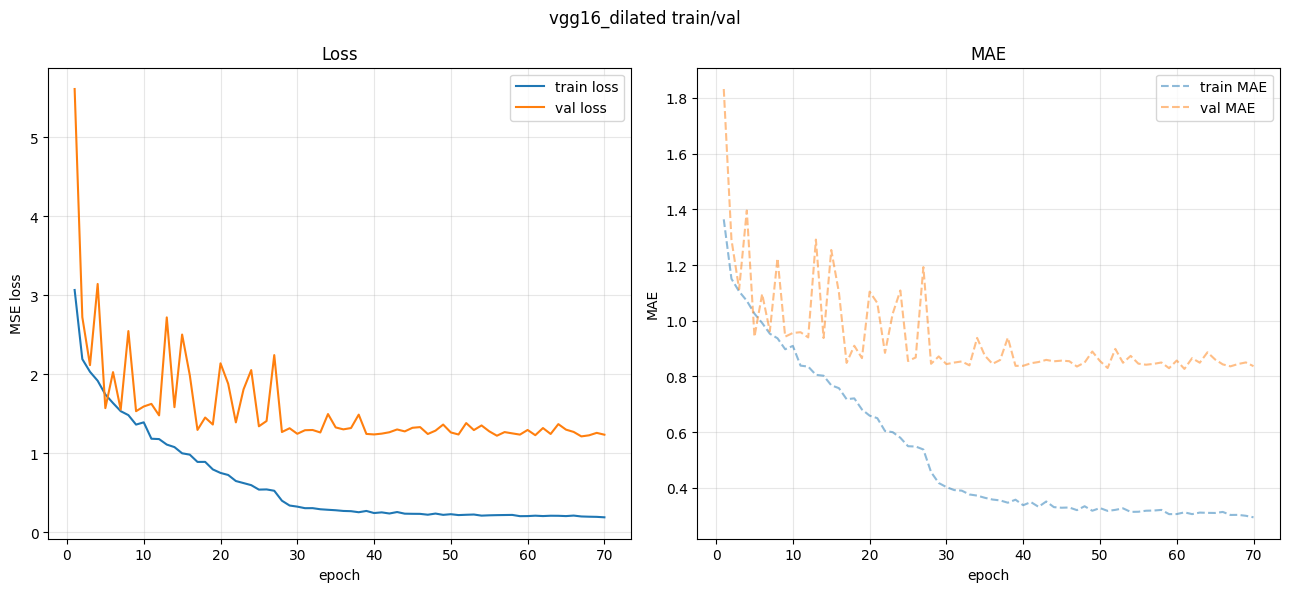

In [ ]:
dilated_vgg= build_model(create_vgg16_dilated_configs(use_batch_norm=True, l2_norm=1e-5, initialization_type="glorot_normal",dropout_only_dense=True,dropout_rate=0.3))
_ = train_with_val(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16_dilated",early_stop=True
)
del dilated_vgg

## Xavier/2 initialization

In [ ]:
dilated_vgg= build_model(create_vgg16_dilated_configs(use_batch_norm=False, l2_norm=1e-4, initialization_type="he_normal"))
_ = train_with_val(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16_dilated",early_stop=True
)
del dilated_vgg

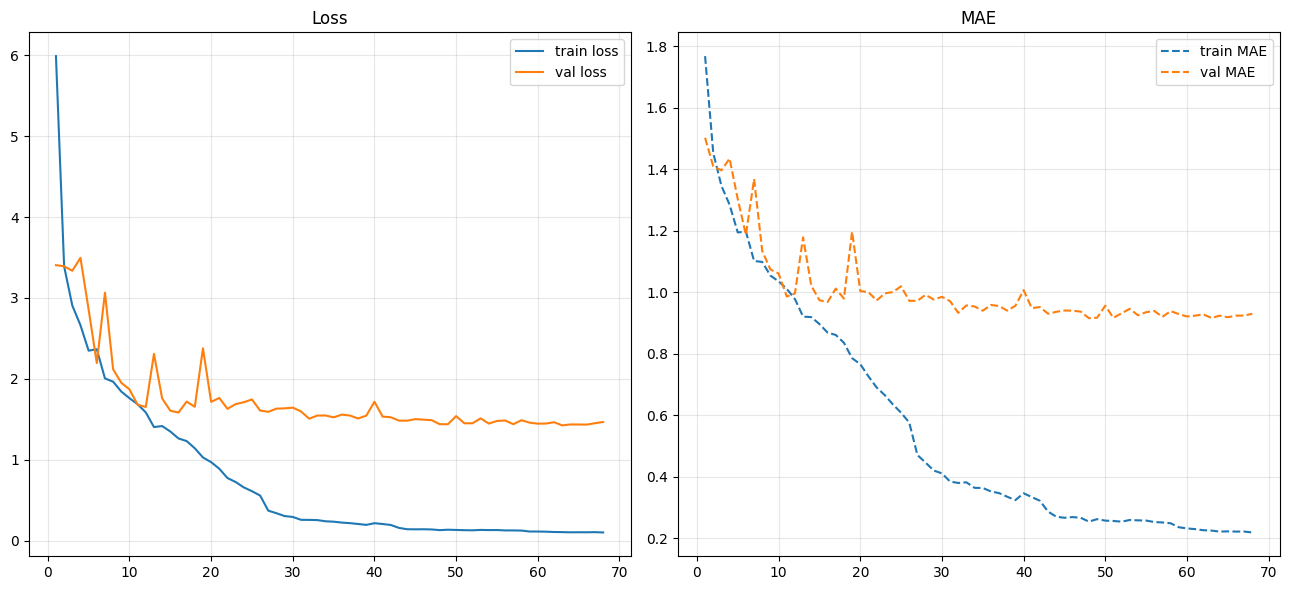

training:  97%|█████████▋ 68/70 [07:54<00:13] , loss=0.1024, mse=0.0842


Epoch 68: ReduceLROnPlateau reducing learning rate to 1.8750000890577212e-05.


Epoch 68: early stopping
Restoring model weights from the end of the best epoch: 48.


[3.40582537651062, 3.3921926021575928, 3.336416721343994, 3.4959723949432373, 2.8567357063293457, 2.1962432861328125, 3.066131591796875, 2.1190004348754883, 1.9519296884536743, 1.8711711168289185, 1.6799614429473877, 1.6535929441452026, 2.309506416320801, 1.7597264051437378, 1.607241153717041, 1.5841838121414185, 1.719440221786499, 1.6556544303894043, 2.3778185844421387, 1.7163923978805542, 1.7648180723190308, 1.6302887201309204, 1.6885818243026733, 1.711874008178711, 1.745907187461853, 1.608880877494812, 1.593552589416504, 1.632439374923706, 1.636052131652832, 1.6450570821762085, 1.5987604856491089, 1.5084381103515625, 1.5469142198562622, 1.5482920408248901, 1.5248194932937622, 1.558685064315796, 1.547435998916626, 1.5108931064605713, 1.546072006225586, 1.7180118560791016, 1.533846378326416, 1.5262103080749512, 1.4843380451202393, 1.4840638637542725, 1.5029374361038208, 1.496471881866455, 1.4901463985443115, 1.4400590658187866, 1.440335750579834, 1.540781855583191, 1.4518342018127441,

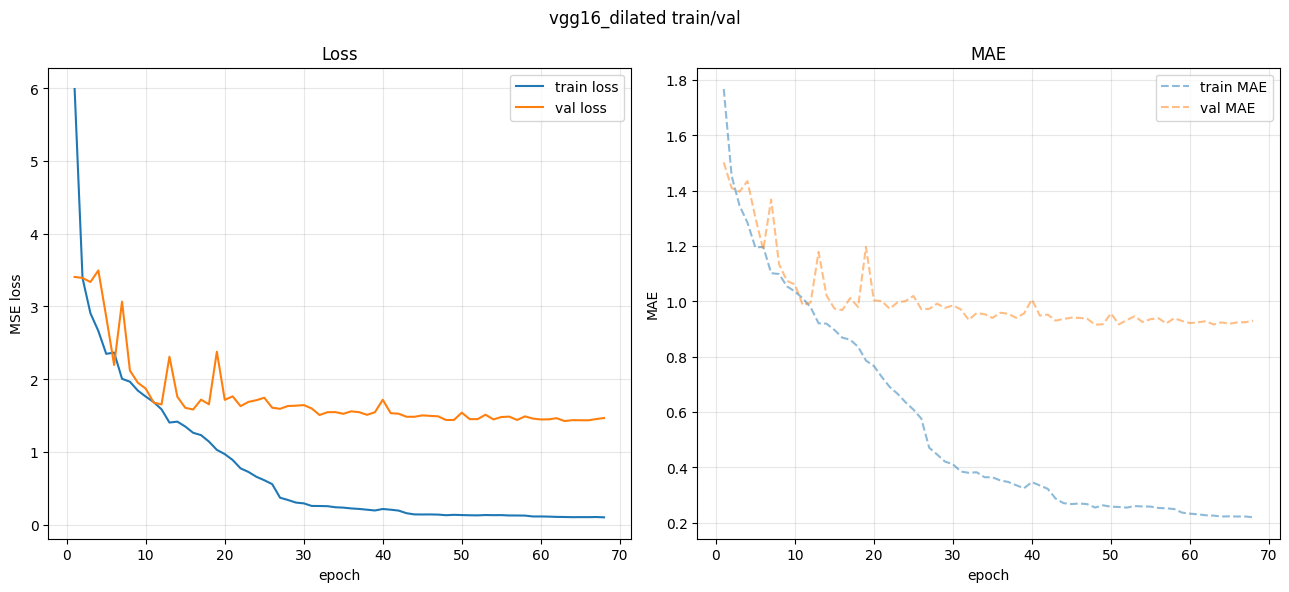

In [ ]:
dilated_vgg= build_model(create_vgg16_dilated_configs(use_batch_norm=False, l2_norm=1e-5, initialization_type="he_normal",dropout_only_dense=False,dropout_rate=0.3))
_ = train_with_val(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16_dilated",early_stop=True
)
del dilated_vgg

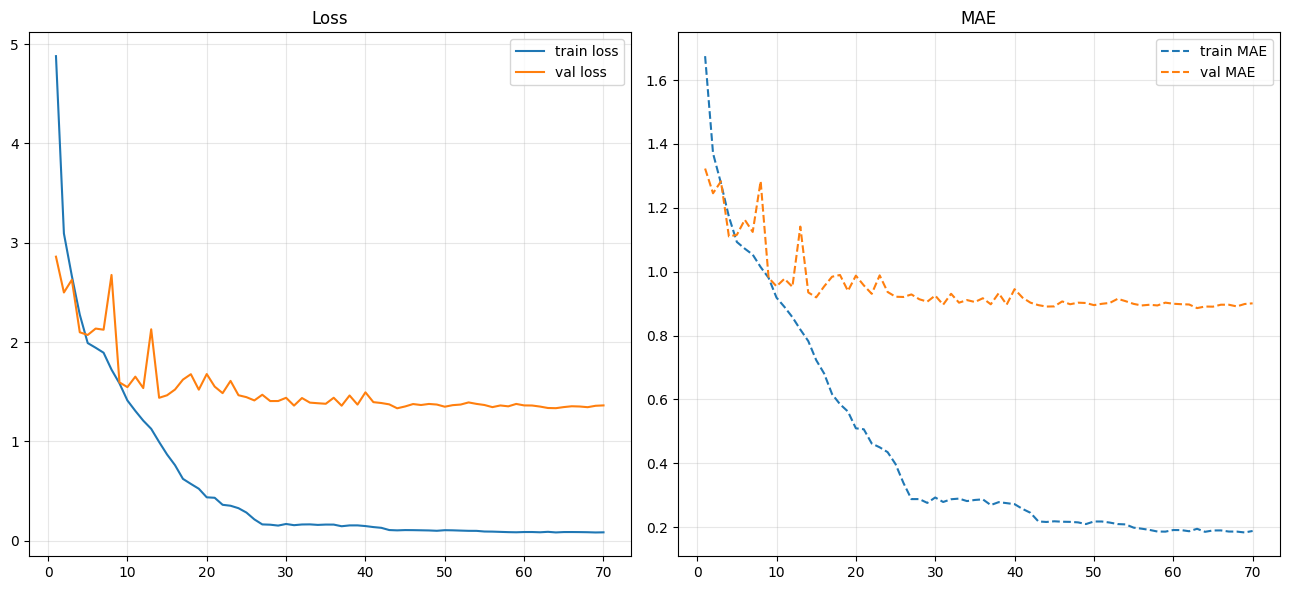

Restoring model weights from the end of the best epoch: 63.


[2.8594744205474854, 2.4989206790924072, 2.6265881061553955, 2.097986936569214, 2.070986270904541, 2.1354212760925293, 2.1239285469055176, 2.675363063812256, 1.593430519104004, 1.5456777811050415, 1.6508512496948242, 1.5358601808547974, 2.1280386447906494, 1.4380173683166504, 1.463560938835144, 1.5211714506149292, 1.621199369430542, 1.6758097410202026, 1.51999831199646, 1.677249789237976, 1.5509333610534668, 1.484955906867981, 1.608431339263916, 1.463908076286316, 1.4445617198944092, 1.411635160446167, 1.4687983989715576, 1.4052209854125977, 1.4055942296981812, 1.4380967617034912, 1.3594881296157837, 1.4356701374053955, 1.3894495964050293, 1.383306622505188, 1.3778704404830933, 1.438489317893982, 1.3585453033447266, 1.4613440036773682, 1.3694425821304321, 1.4931023120880127, 1.3942893743515015, 1.385466456413269, 1.3719348907470703, 1.332424521446228, 1.3509095907211304, 1.3750823736190796, 1.365365982055664, 1.3761701583862305, 1.3700464963912964, 1.3482639789581299, 1.363985180854797

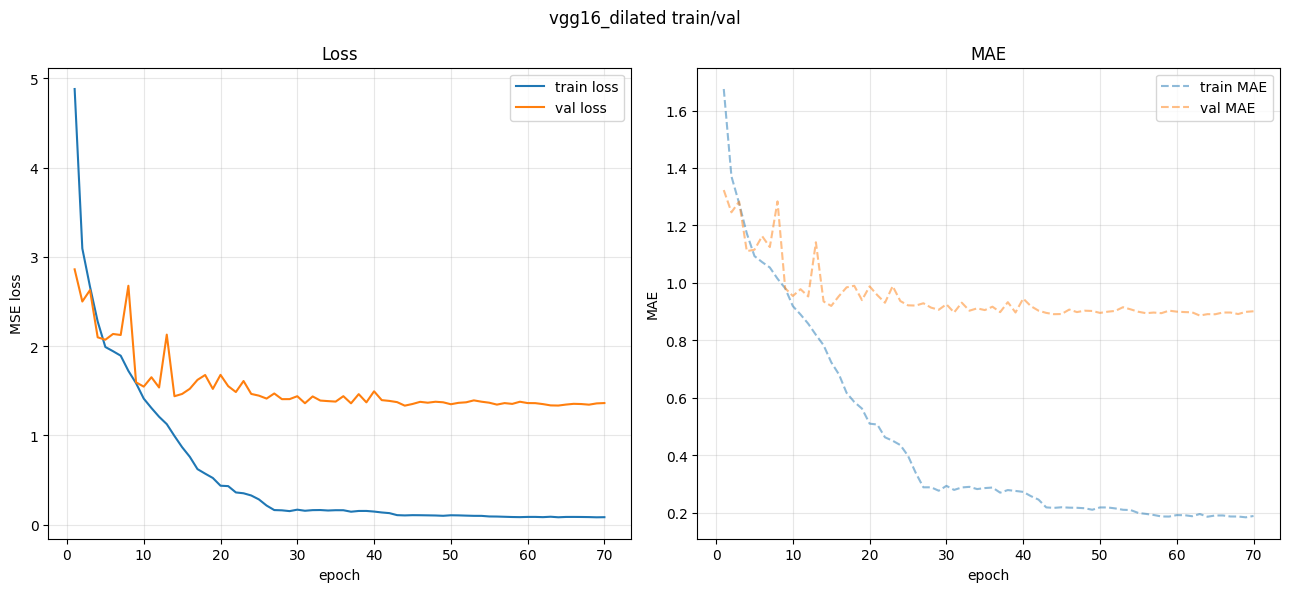

In [ ]:
dilated_vgg= build_model(create_vgg16_dilated_configs(use_batch_norm=False, l2_norm=1e-5, initialization_type="he_normal",dropout_only_dense=True,dropout_rate=0.3))
_ = train_with_val(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16_dilated",early_stop=True
)
del dilated_vgg

## Random Initialization

In [ ]:
dilated_vgg= build_model(create_vgg16_dilated_configs(use_batch_norm=False, l2_norm=1e-4, initialization_type="random_normal"))
_ = train_with_val(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16_dilated",early_stop=True
)
del dilated_vgg

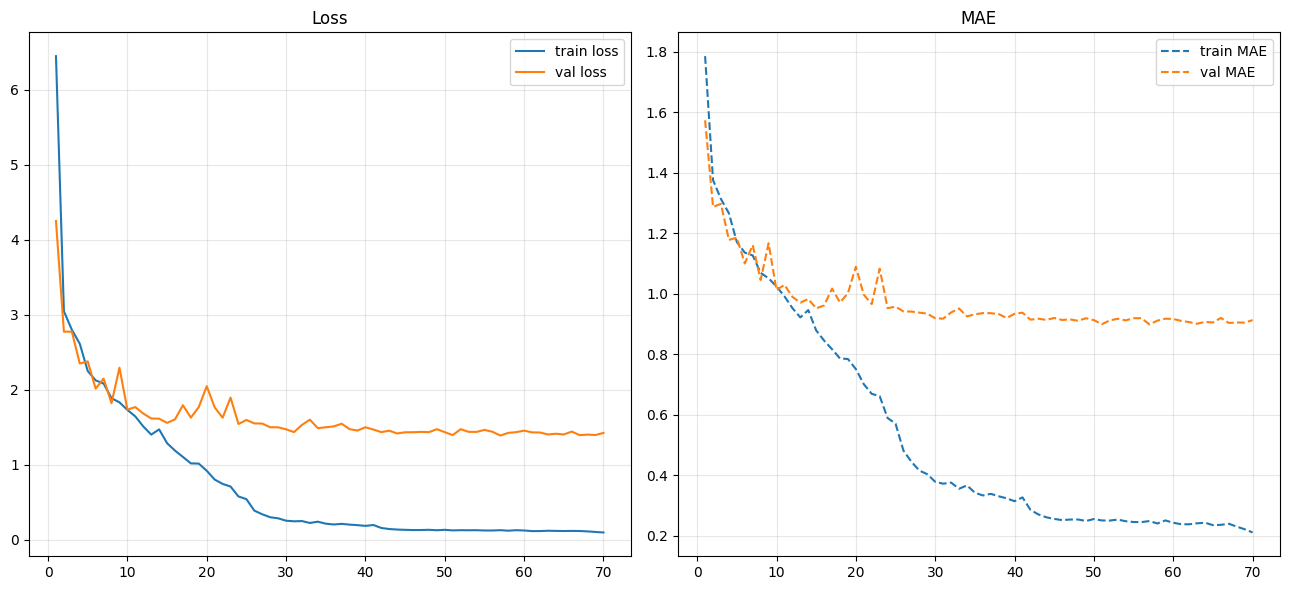

Restoring model weights from the end of the best epoch: 57.


[4.247673511505127, 2.772920608520508, 2.7727272510528564, 2.3480918407440186, 2.3761558532714844, 2.014040231704712, 2.147608518600464, 1.819652795791626, 2.2921159267425537, 1.733848214149475, 1.767374873161316, 1.681942343711853, 1.6154518127441406, 1.6129792928695679, 1.5568565130233765, 1.6038117408752441, 1.7928314208984375, 1.6268281936645508, 1.768457055091858, 2.0462074279785156, 1.764313817024231, 1.6264532804489136, 1.8938616514205933, 1.5422301292419434, 1.5958456993103027, 1.5499628782272339, 1.5478848218917847, 1.4986368417739868, 1.4980647563934326, 1.4709140062332153, 1.4344147443771362, 1.5302313566207886, 1.599786400794983, 1.4863102436065674, 1.4983876943588257, 1.5099800825119019, 1.5459682941436768, 1.473556637763977, 1.4551734924316406, 1.4987843036651611, 1.46807062625885, 1.433742880821228, 1.453007459640503, 1.4158614873886108, 1.4318617582321167, 1.4322208166122437, 1.4369351863861084, 1.4332282543182373, 1.4730125665664673, 1.4333184957504272, 1.3942837715148

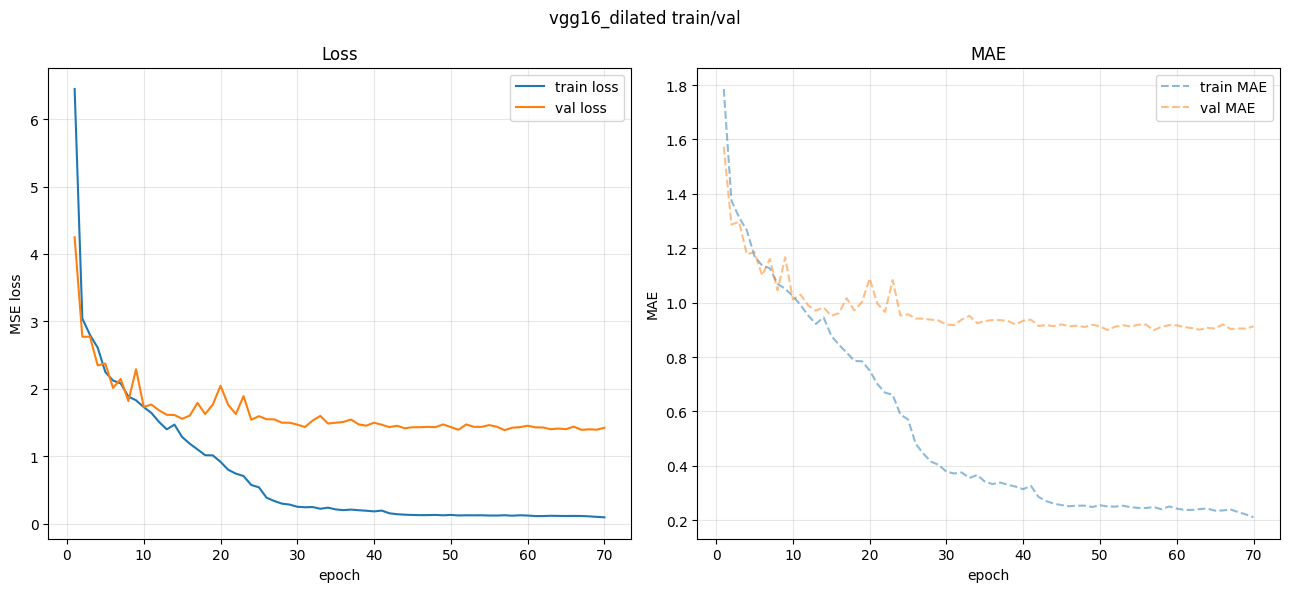

In [ ]:
dilated_vgg= build_model(create_vgg16_dilated_configs(use_batch_norm=False, l2_norm=1e-5, initialization_type="random_normal",dropout_only_dense=False,dropout_rate=0.3))
_ = train_with_val(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16_dilated",early_stop=True
)
del dilated_vgg

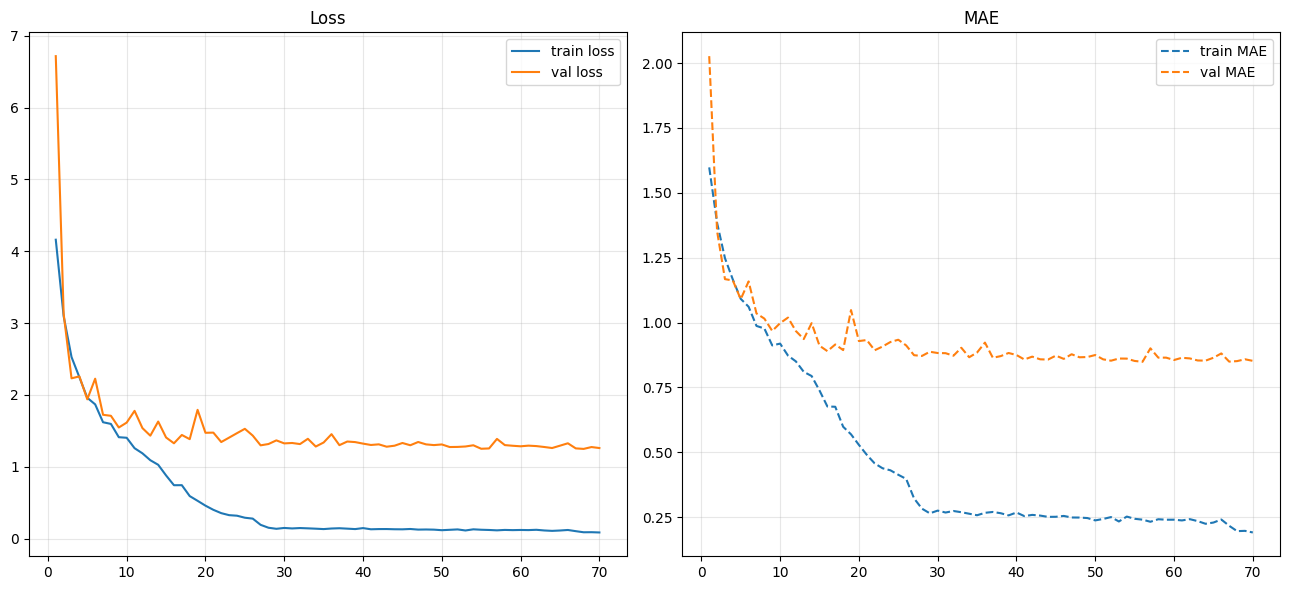

Restoring model weights from the end of the best epoch: 56.


[6.717059135437012, 3.128272771835327, 2.230903387069702, 2.2576756477355957, 1.9384198188781738, 2.2256078720092773, 1.7229746580123901, 1.7089883089065552, 1.546116828918457, 1.6143981218338013, 1.777912974357605, 1.5376700162887573, 1.432227373123169, 1.6289721727371216, 1.4070193767547607, 1.3261804580688477, 1.4422298669815063, 1.383568286895752, 1.7919652462005615, 1.4723633527755737, 1.4748238325119019, 1.3436089754104614, 1.4050319194793701, 1.4670791625976562, 1.5277767181396484, 1.4334051609039307, 1.2977744340896606, 1.3159428834915161, 1.3668595552444458, 1.3247618675231934, 1.330395221710205, 1.315256118774414, 1.388755440711975, 1.2810438871383667, 1.337315320968628, 1.4533214569091797, 1.300168752670288, 1.350716471672058, 1.3428783416748047, 1.321651577949524, 1.3027442693710327, 1.3115472793579102, 1.2786818742752075, 1.2925760746002197, 1.3303170204162598, 1.2989437580108643, 1.3440979719161987, 1.311038613319397, 1.301091194152832, 1.3100885152816772, 1.2741214036941

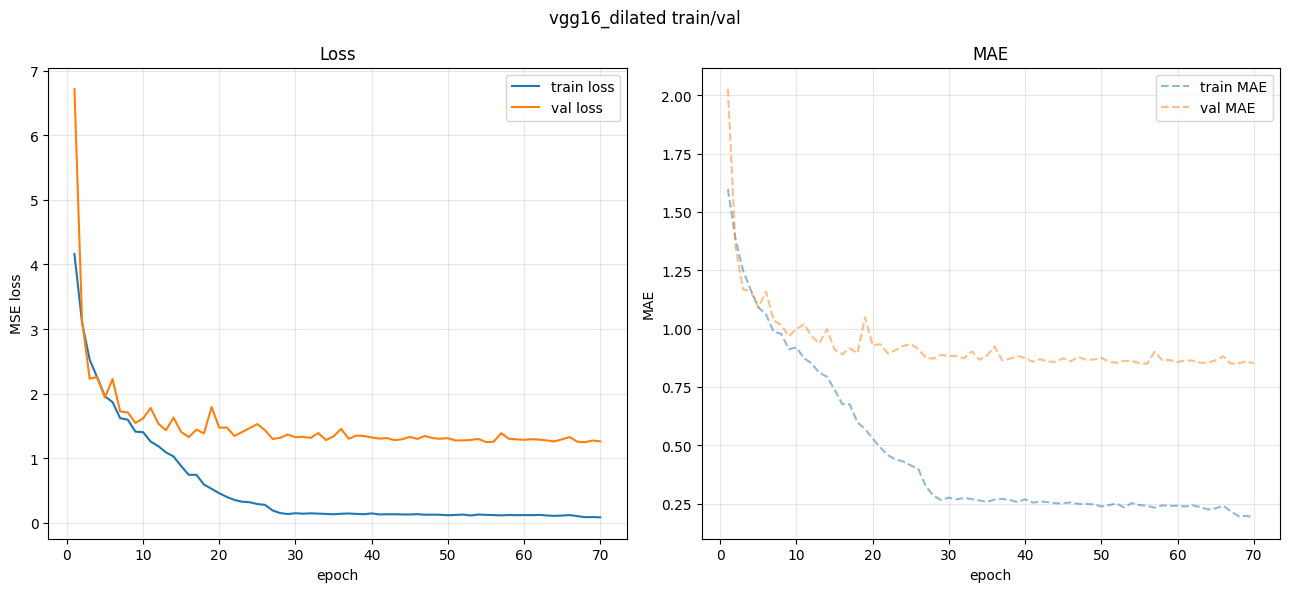

In [ ]:
dilated_vgg= build_model(create_vgg16_dilated_configs(use_batch_norm=False, l2_norm=1e-5, initialization_type="random_normal",dropout_only_dense=True,dropout_rate=0.3))
_ = train_with_val(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16_dilated",early_stop=True
)
del dilated_vgg

## Different Loss Trials

In [ ]:
def ranking_loss(y_true, y_pred):
    # build pairwise differences within batch
    y_true = tf.reshape(y_true, (-1,))
    y_pred = tf.reshape(y_pred, (-1,))
    y_diff  = tf.expand_dims(y_true, 1) - tf.expand_dims(y_true, 0)
    y_pred_diff = tf.expand_dims(y_pred, 1) - tf.expand_dims(y_pred, 0)
    mask = tf.cast(y_diff > 0, tf.float32)
    loss = tf.math.log1p(tf.exp(-y_pred_diff)) * mask   # logistic ranking
    return tf.reduce_mean(loss)

def attractiveness_loss(y_true, y_pred, alpha=1.0, beta=0.2):
    huber = tf.keras.losses.Huber(delta=1.0)(y_true, y_pred)
    rank  = ranking_loss(y_true, y_pred)
    return alpha * huber + beta * rank

In [ ]:
def train_with_val_custom_loss(
        model,
        train_ds_full,
        val_ds_full,
        epochs=100,
        batch_size=32,
        lr=1e-3,
        name="model",
        early_stop=True,
        loss_fn="mse"      # can be "mse", "mae", "huber", "attractiveness"
    ):

    train_ds = prepare_train(train_ds_full, batch_size=batch_size)
    val_ds   = prepare_val(val_ds_full, batch_size=batch_size)

    # build once (subclassed model)
    x0, _ = next(iter(train_ds))
    _ = model(x0, training=True)

    # choose loss ---------------------------------------------------------------
    if loss_fn == "mse":
        loss = tf.keras.losses.MeanSquaredError()
    elif loss_fn == "mae":
        loss = tf.keras.losses.MeanAbsoluteError()
    elif loss_fn == "huber":
        loss = tf.keras.losses.Huber(delta=1.0)
    elif loss_fn == "attractiveness":
        # composite regression + ranking
        loss = attractiveness_loss
    else:
        raise ValueError(f"Unknown loss type: {loss_fn}")
    # --------------------------------------------------------------------------

    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(
        optimizer=opt,
        loss=loss,
        metrics=[
            tf.keras.metrics.MeanSquaredError(name="mse"),
            tf.keras.metrics.MeanAbsoluteError(name="mean_absolute_error"),
        ]
    )

    for layer in model.layers:
        if hasattr(layer, "kernel_regularizer") and layer.kernel_regularizer:
            print(f"{layer.name}: L2 = {layer.kernel_regularizer.l2}")

    # callbacks ----------------------------------------------------------------
    cbs = [LivePlot(), SingleBar(), callbacks.TerminateOnNaN()]
    if early_stop:
        cbs += [
            callbacks.ReduceLROnPlateau(
                monitor="val_mean_absolute_error",
                factor=0.5,
                patience=10,
                min_lr=1e-6,
                verbose=1,
                mode="min",
            ),
            callbacks.EarlyStopping(
                monitor="val_mean_absolute_error",
                patience=20,
                restore_best_weights=True,
                verbose=1,
                mode="min",
            ),
        ]
    # --------------------------------------------------------------------------

    print(f"\n[train] {name} | lr={lr} | bs={batch_size} | epochs={epochs} | loss={loss_fn}")
    h = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        verbose=0,
        callbacks=cbs,
    ).history

    # summary ------------------------------------------------------------------
    last_idx = len(h["loss"]) - 1
    best_idx = (np.nanargmin(h["val_mean_absolute_error"])
                if "val_mean_absolute_error" in h and len(h["val_mean_absolute_error"]) > 0
                else last_idx)
    last = {
        "epoch": last_idx + 1,
        "loss": h["loss"][last_idx],
        "val_loss": h.get("val_loss", [np.nan])[last_idx],
        "mae": h.get("mean_absolute_error", [np.nan])[last_idx],
        "val_mae": h.get("val_mean_absolute_error", [np.nan])[last_idx],
    }
    best = {
        "epoch": best_idx + 1,
        "loss": h["loss"][best_idx],
        "val_loss": h.get("val_loss", [np.nan])[best_idx],
        "mae": h.get("mean_absolute_error", [np.nan])[best_idx],
        "val_mae": h.get("val_mean_absolute_error", [np.nan])[best_idx],
    }

    print(f"[{name}] LAST @ epoch {last['epoch']}: "
          f"loss={last['loss']:.4f} | val_loss={last['val_loss']:.4f} | "
          f"MAE={last['mae']:.4f} | val_MAE={last['val_mae']:.4f}")

    print(f"[{name}] BEST (val_MAE) @ epoch {best['epoch']}: "
          f"loss={best['loss']:.4f} | val_loss={best['val_loss']:.4f} | "
          f"MAE={best['mae']:.4f} | val_MAE={best['val_mae']:.4f}")

    plot_train_val_history(h, title=f"{name} train/val")

    return h

In [ ]:
general_epochs=200

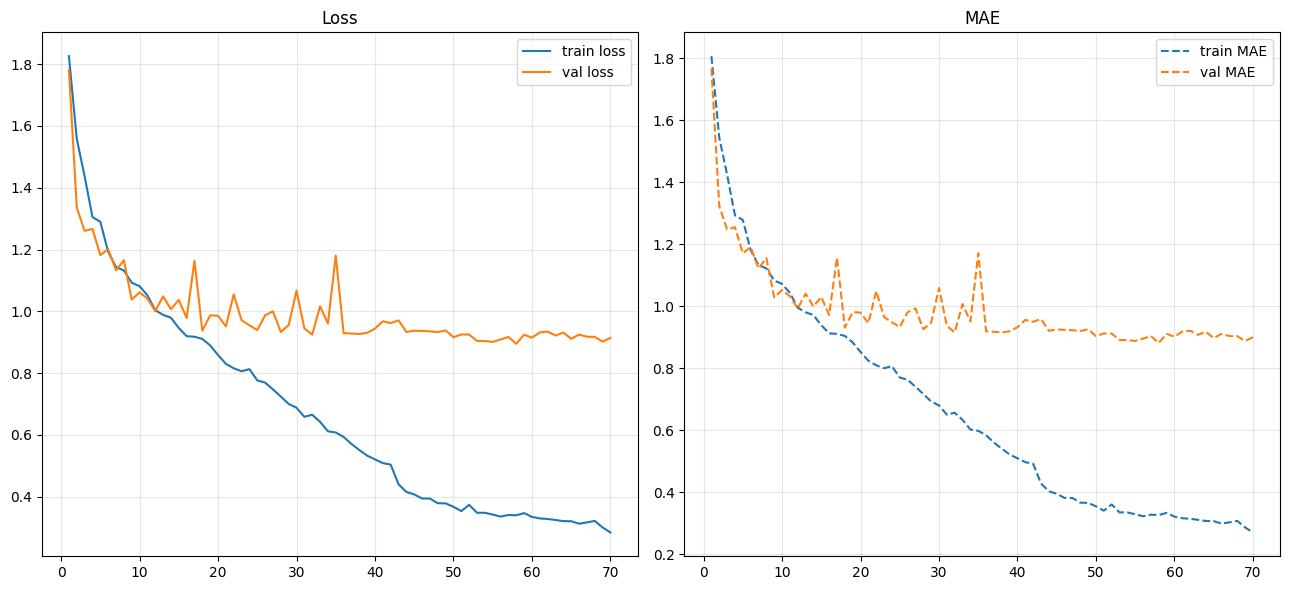

Restoring model weights from the end of the best epoch: 58.


[vgg16_dilated] LAST @ epoch 70: loss=0.2845 | val_loss=0.9141 | MAE=0.2708 | val_MAE=0.9004
[vgg16_dilated] BEST (val_MAE) @ epoch 58: loss=0.3401 | val_loss=0.8952 | MAE=0.3270 | val_MAE=0.8822


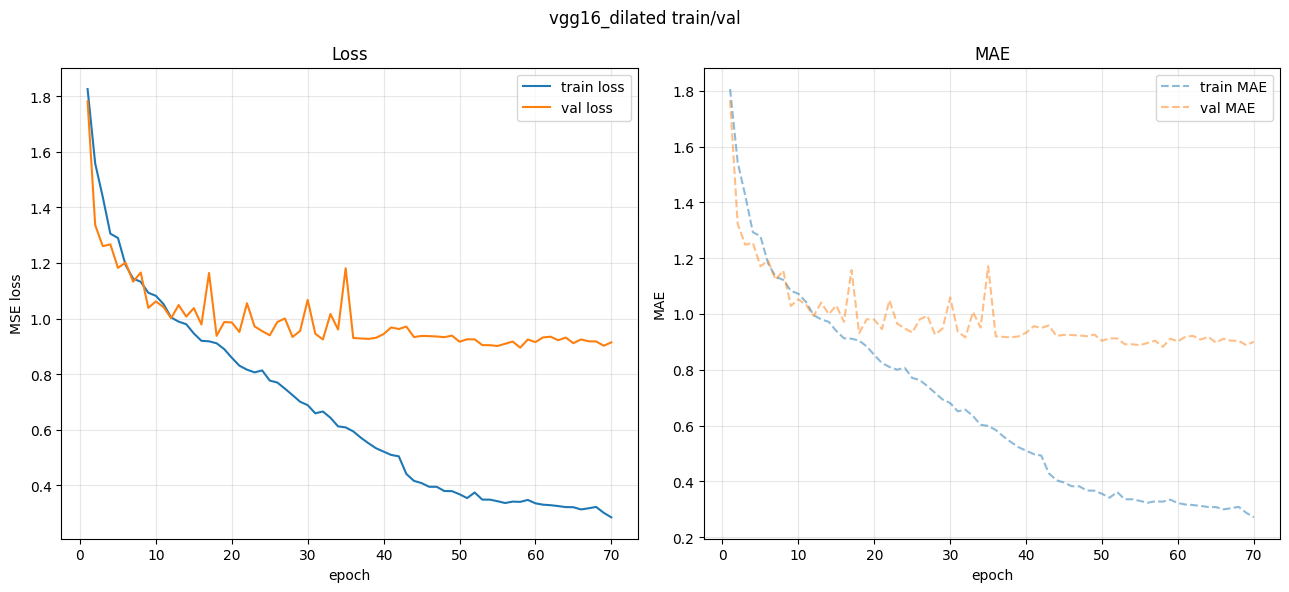

In [ ]:
dilated_vgg= build_model(create_vgg16_dilated_configs(use_batch_norm=False, l2_norm=1e-5, initialization_type="glorot_normal",dropout_only_dense=False,dropout_rate=0.3))
_ = train_with_val_custom_loss(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16_dilated",early_stop=True, loss_fn="mae"
)
del dilated_vgg

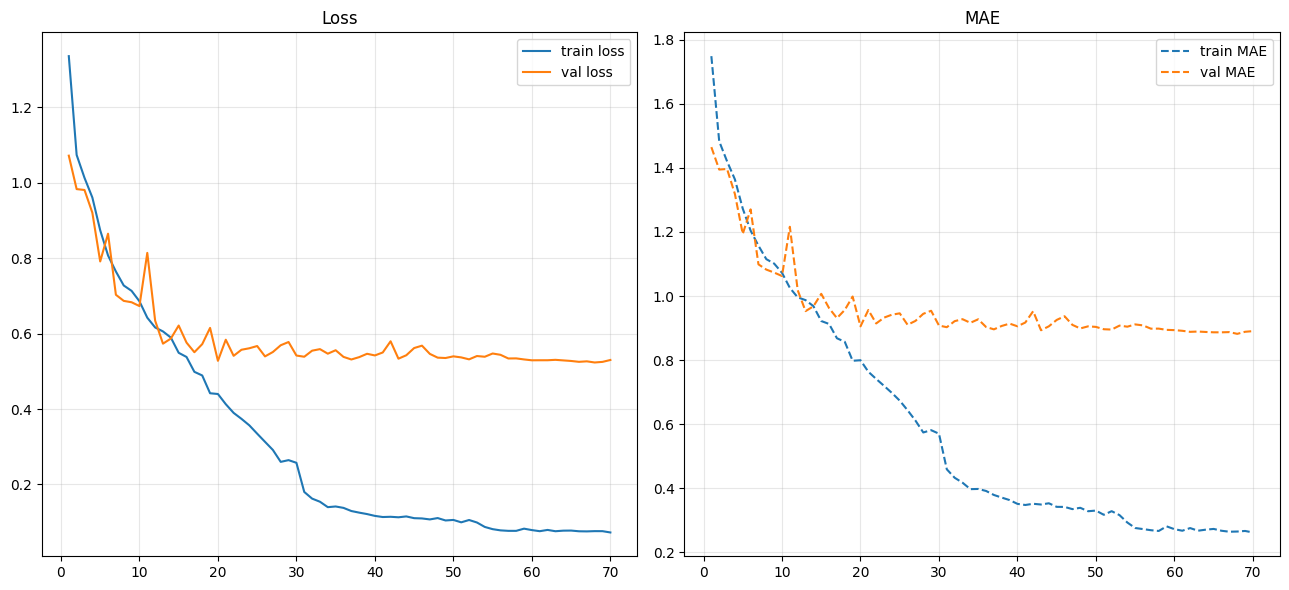

Restoring model weights from the end of the best epoch: 68.


[vgg16_dilated] LAST @ epoch 70: loss=0.0726 | val_loss=0.5301 | MAE=0.2615 | val_MAE=0.8904
[vgg16_dilated] BEST (val_MAE) @ epoch 68: loss=0.0761 | val_loss=0.5235 | MAE=0.2644 | val_MAE=0.8819


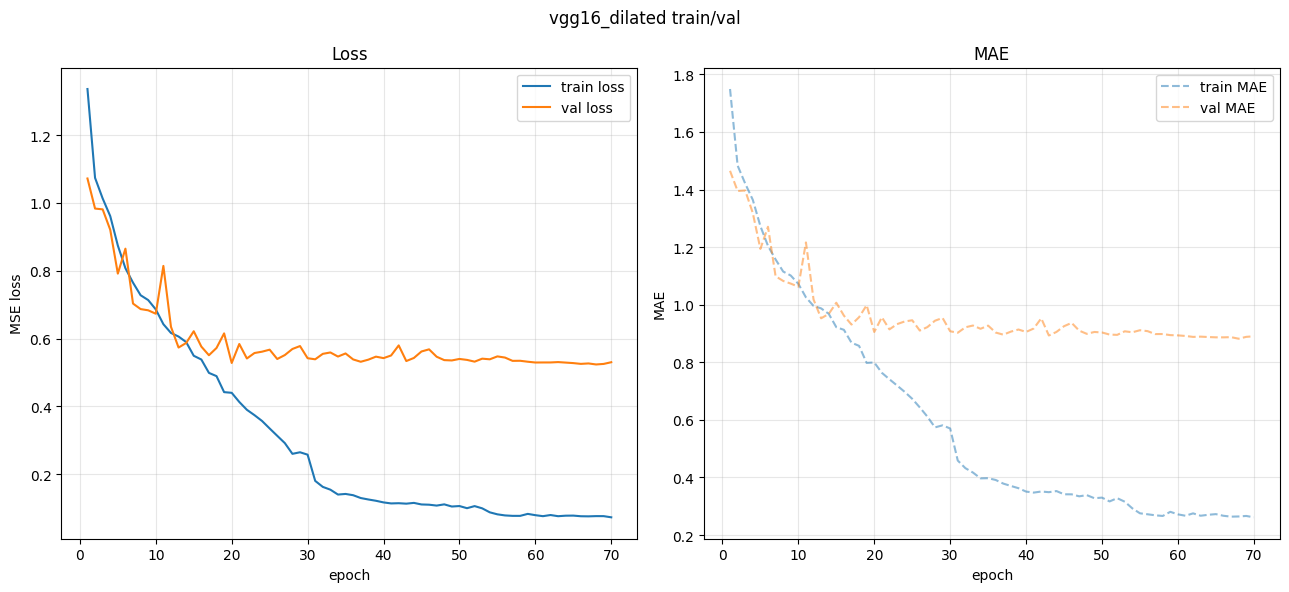

In [ ]:
dilated_vgg= build_model(create_vgg16_dilated_configs(use_batch_norm=False, l2_norm=1e-5, initialization_type="glorot_normal",dropout_only_dense=False,dropout_rate=0.4))
_ = train_with_val_custom_loss(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16_dilated",early_stop=True, loss_fn="huber"
)
del dilated_vgg

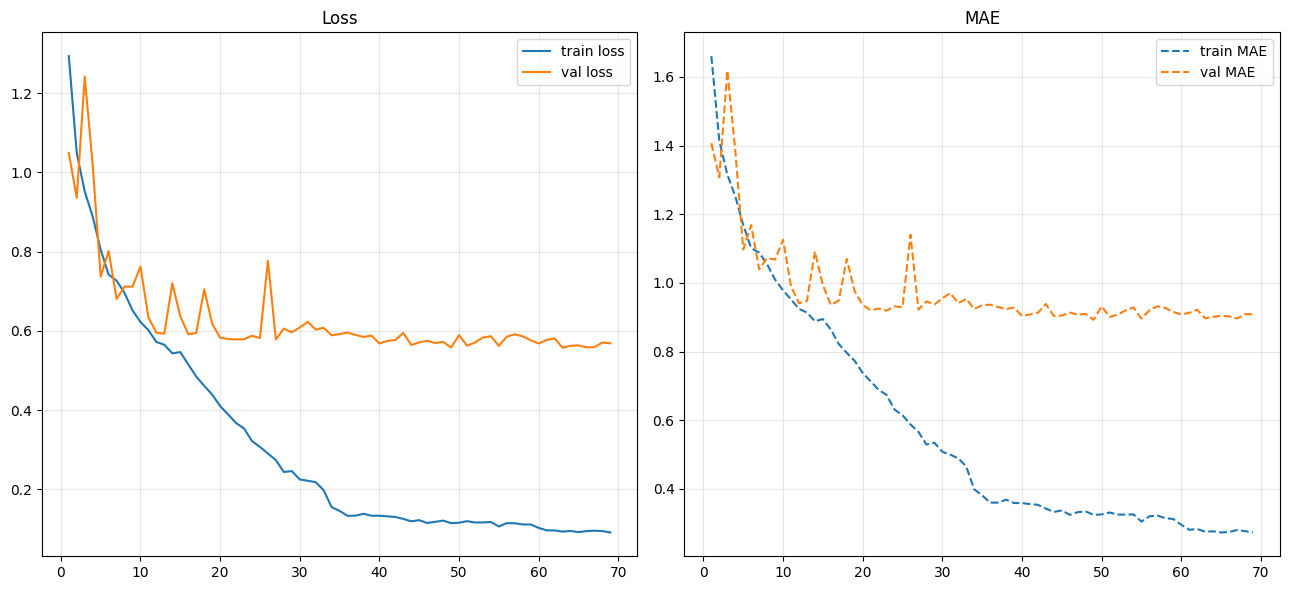

training:  99%|█████████▊ 69/70 [08:06<00:07] , loss=0.0911, mse=0.1307


Epoch 69: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.


Epoch 69: early stopping
Restoring model weights from the end of the best epoch: 49.


[vgg16_dilated] LAST @ epoch 69: loss=0.0911 | val_loss=0.5686 | MAE=0.2731 | val_MAE=0.9085
[vgg16_dilated] BEST (val_MAE) @ epoch 49: loss=0.1146 | val_loss=0.5578 | MAE=0.3244 | val_MAE=0.8926


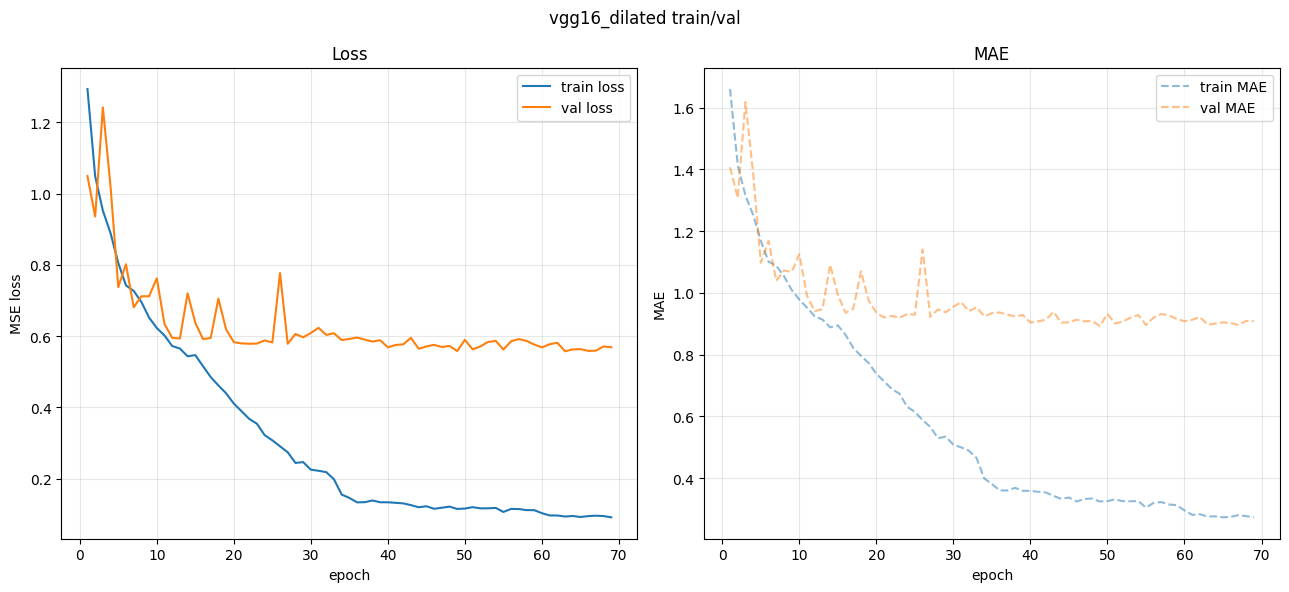

In [ ]:
dilated_vgg= build_model(create_vgg16_dilated_configs(use_batch_norm=False, l2_norm=1e-5, initialization_type="glorot_normal",dropout_only_dense=True,dropout_rate=0.4))
_ = train_with_val_custom_loss(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16_dilated",early_stop=True, loss_fn="attractiveness"
)
del dilated_vgg

# Dropout only last layer

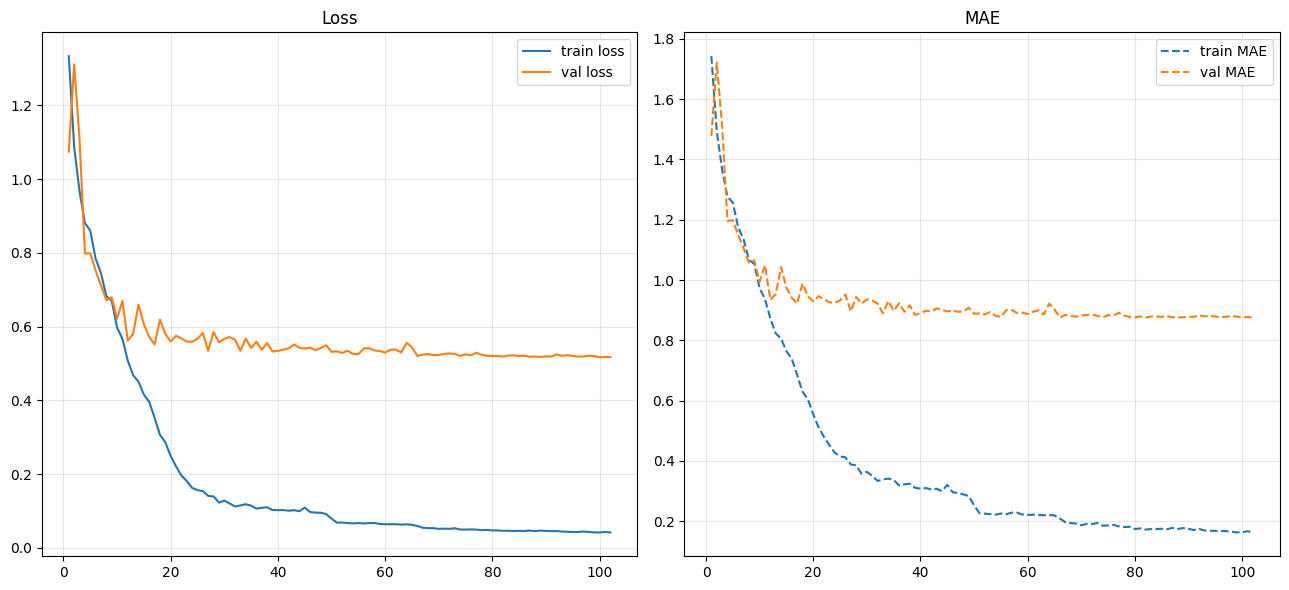

training:  51%|█████      102/200 [11:37<10:57] , loss=0.0419, mse=0.0525


Epoch 102: ReduceLROnPlateau reducing learning rate to 9.375000445288606e-06.


Epoch 102: early stopping
Restoring model weights from the end of the best epoch: 82.


[vgg16_dilated] LAST @ epoch 102: loss=0.0419 | val_loss=0.5173 | MAE=0.1630 | val_MAE=0.8754
[vgg16_dilated] BEST (val_MAE) @ epoch 82: loss=0.0464 | val_loss=0.5187 | MAE=0.1728 | val_MAE=0.8754


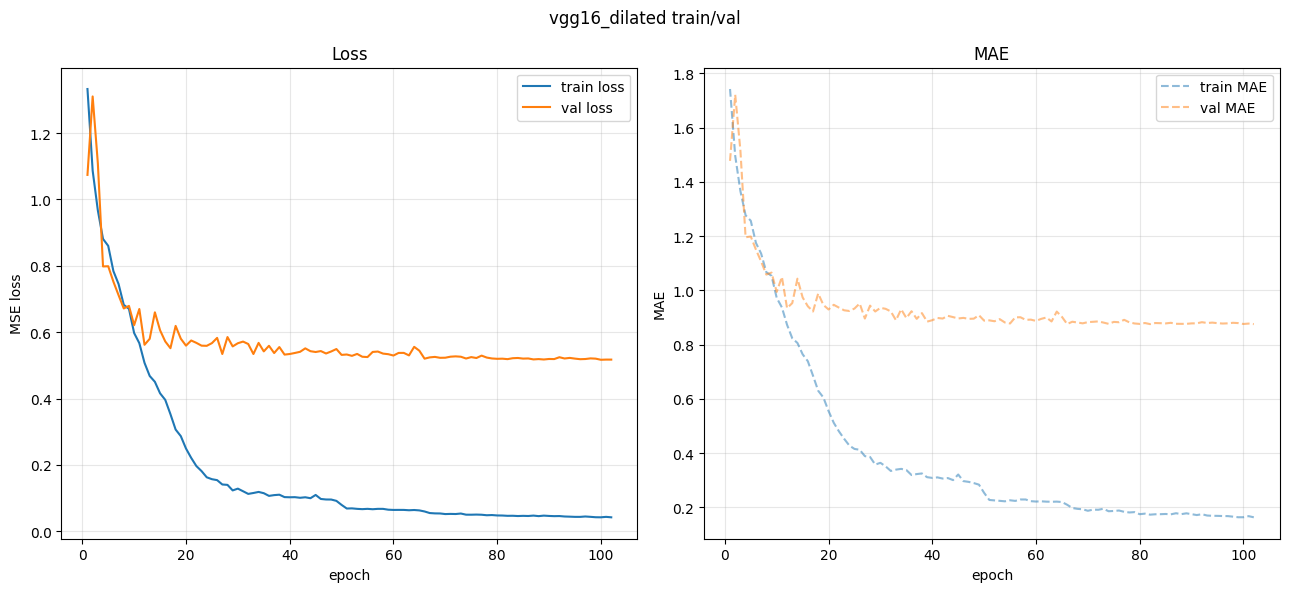

In [ ]:
dilated_vgg= build_model(create_vgg16_dilated_configs(use_batch_norm=False, l2_norm=1e-5, initialization_type="he_normal",dropout_only_dense=True,dropout_rate=0.3))
_ = train_with_val_custom_loss(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16_dilated",early_stop=True, loss_fn="huber"
)
del dilated_vgg

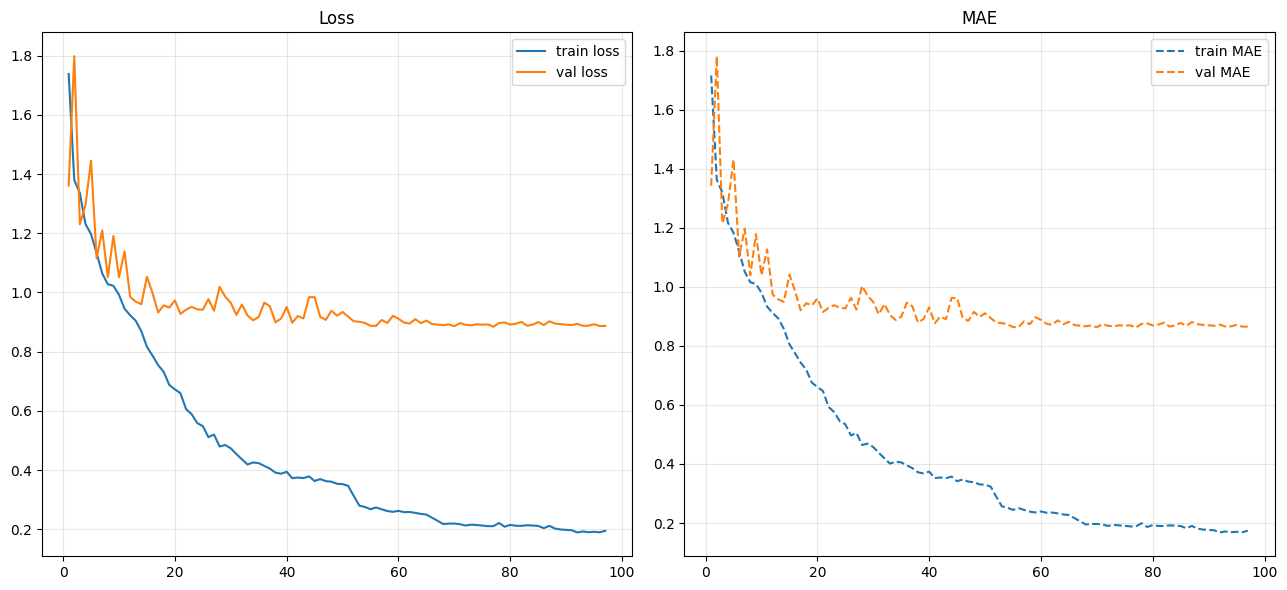

training:  48%|████▊      97/200 [11:00<11:32] , loss=0.1950, mse=0.0582


Epoch 97: ReduceLROnPlateau reducing learning rate to 1.8750000890577212e-05.


Epoch 97: early stopping
Restoring model weights from the end of the best epoch: 77.


[vgg16_dilated] LAST @ epoch 97: loss=0.1950 | val_loss=0.8870 | MAE=0.1737 | val_MAE=0.8657
[vgg16_dilated] BEST (val_MAE) @ epoch 77: loss=0.2109 | val_loss=0.8843 | MAE=0.1887 | val_MAE=0.8621


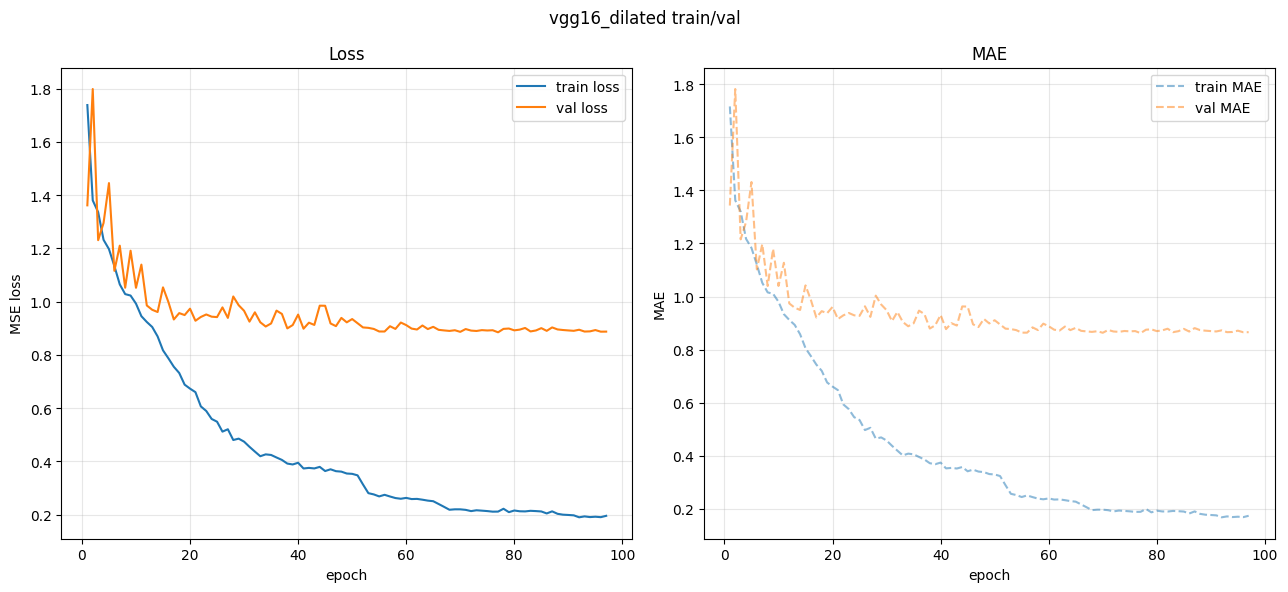

In [ ]:
dilated_vgg= build_model(create_vgg16_dilated_configs(use_batch_norm=False, l2_norm=1e-5, initialization_type="he_normal",dropout_only_dense=True,dropout_rate=0.3))
_ = train_with_val_custom_loss(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16_dilated",early_stop=True, loss_fn="mae"
)
del dilated_vgg

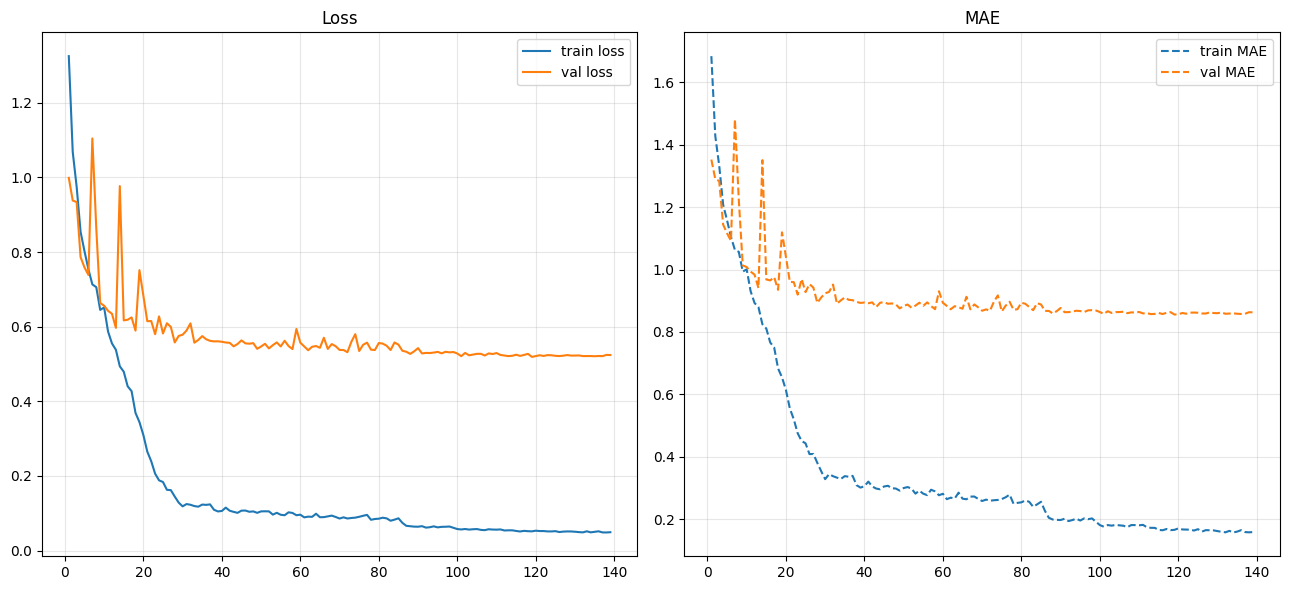

training:  70%|██████▉    139/200 [11:22<05:02] , loss=0.0493, mse=0.0495


Epoch 139: ReduceLROnPlateau reducing learning rate to 9.375000445288606e-06.


Epoch 139: early stopping
Restoring model weights from the end of the best epoch: 119.


[vgg16_dilated] LAST @ epoch 139: loss=0.0493 | val_loss=0.5240 | MAE=0.1586 | val_MAE=0.8628
[vgg16_dilated] BEST (val_MAE) @ epoch 119: loss=0.0516 | val_loss=0.5190 | MAE=0.1657 | val_MAE=0.8557


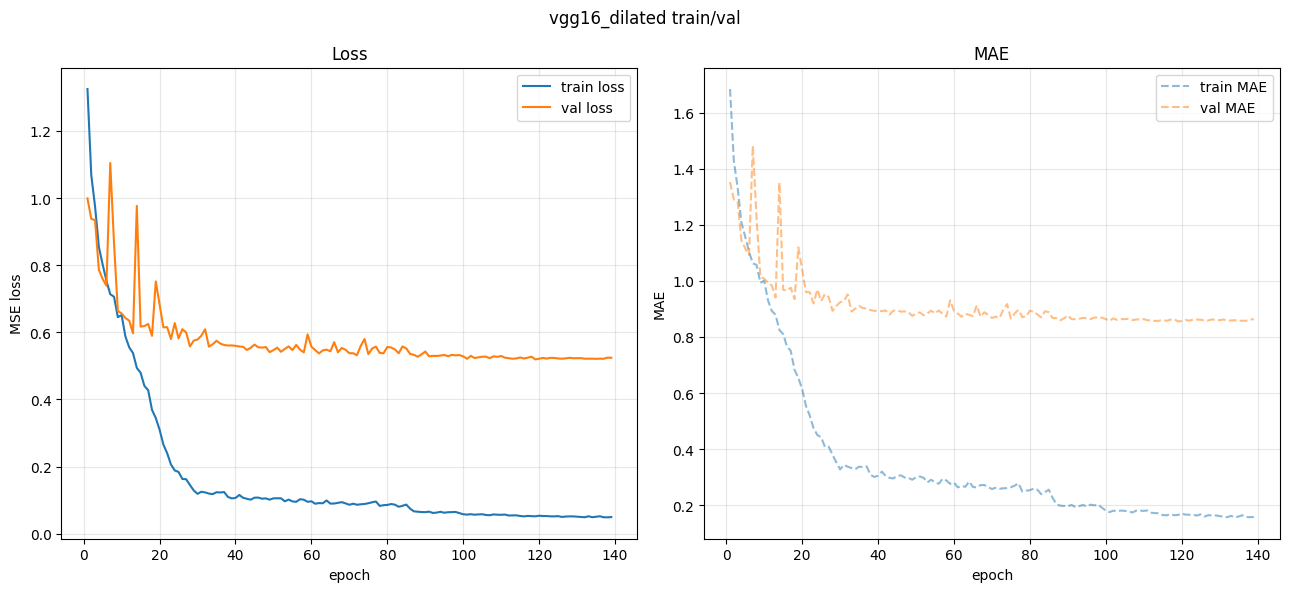

In [ ]:
dilated_vgg= build_model(create_vgg16_dilated_configs(use_batch_norm=False, l2_norm=1e-5, initialization_type="he_normal",dropout_only_dense=True,dropout_rate=0.3))
_ = train_with_val_custom_loss(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size*2, lr=general_learning_rate, name="vgg16_dilated",early_stop=True, loss_fn="attractiveness"
)
del dilated_vgg